# <span style="font-family:cursive;text-align:center">⬇️ Import Libraries</span>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from category_encoders import TargetEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso, RANSACRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import optuna
import tqdm
import joblib
import pickle
import shap

pd.set_option('display.max_columns', 70)
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False

style.use('ggplot')
sns.set_palette('Set2')

import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('../data/train_dataset.csv')
test = pd.read_csv('../data/x_test.csv')

In [4]:
df_train = train.copy()
print(df_train.shape)
df_test = test.copy()
print(df_test.shape)

(75757, 64)
(9705, 63)


In [5]:
train

Year_Factor State_Factor building_class  \
0                1      State_1     Commercial   
1                1      State_1     Commercial   
2                1      State_1     Commercial   
3                1      State_1     Commercial   
4                1      State_1     Commercial   
...            ...          ...            ...   
75752            6     State_11     Commercial   
75753            6     State_11    Residential   
75754            6     State_11     Commercial   
75755            6     State_11     Commercial   
75756            6     State_11    Residential   

                                   facility_type  floor_area  year_built  \
0                   Grocery_store_or_food_market     61242.0      1942.0   
1      Warehouse_Distribution_or_Shipping_center    274000.0      1955.0   
2                           Retail_Enclosed_mall    280025.0      1951.0   
3                      Education_Other_classroom     55325.0      1980.0   
4                      Warehouse_Nonrefrigerated     66000.0      1985.0   
...                                          ...         ...         ...   
75752                       Office_Uncategorized     20410.0      1995.0   
75753                        5plus_Unit_Building     40489.0      1910.0   
75754                           Commercial_Other     28072.0      1917.0   
75755                           Commercial_Other     53575.0      2012.0   
75756                         2to4_Unit_Building     23888.0      1974.0   

       energy_star_rating  ELEVATION  january_min_temp  january_avg_temp  \
0                    11.0        2.4                36         50.500000   
1                    45.0        1.8                36         50.500000   
2                    97.0        1.8                36         50.500000   
3                    46.0        1.8                36         50.500000   
4                   100.0        2.4                36         50.500000   
...                   ...        ...               ...               ...   
75752                 8.0       36.6                28         43.451613   
75753                98.0       36.6                28         43.451613   
75754                 NaN       36.6                26         36.612903   
75755                 NaN       36.6                26         36.612903   
75756                51.0       36.6                27         36.935484   

       january_max_temp  february_min_temp  february_avg_temp  \
0                    68                 35          50.589286   
1                    68                 35          50.589286   
2                    68                 35          50.589286   
3                    68                 35          50.589286   
4                    68                 35          50.589286   
...                 ...                ...                ...   
75752                56                 34          47.672414   
75753                56                 34          47.672414   
75754                48                 30          41.637931   
75755                48                 30          41.637931   
75756                51                 29          42.172414   

       february_max_temp  march_min_temp  march_avg_temp  march_max_temp  \
0                     73              40       53.693548              80   
1                     73              40       53.693548              80   
2                     73              40       53.693548              80   
3                     73              40       53.693548              80   
4                     73              40       53.693548              80   
...                  ...             ...             ...             ...   
75752                 64              35       49.354839              71   
75753                 64              35       49.354839              71   
75754                 58              29       41.338710              62   
75755                 58              2

In [6]:
df_train.rename(columns={
    'Year_Factor': 'year_factor', 
    'State_Factor': 'state_factor',
    'ELEVATION': 'elevation',
    'id': 'building_id'
}, inplace=True)

df_test.rename(columns={
    'Year_Factor': 'year_factor', 
    'State_Factor': 'state_factor',
    'ELEVATION': 'elevation',
    'id': 'building_id'
}, inplace=True)

# df.columns = df.columns.values.lower()

<b> Data Dictionary </b>

<b> Covariates </b>


year_Factor: anonymized year in which the weather and energy usage factors were observed  

state_Factor: anonymized state in which the building is located  

building_class: building classification  

facility_type: building usage type  

floor_area: floor area (in square feet) of the building  

year_built: year in which the building was constructed  

energy_star_rating: the energy star rating of the building  

elevation: elevation of the building location  

january_min_temp: minimum temperature in January (in Fahrenheit) at the location of the building  

january_avg_temp: average temperature in January (in Fahrenheit) at the location of the building  

january_max_temp: maximum temperature in January (in Fahrenheit) at the location of the building  

[Similarly for all other months]

cooling_degree_days: cooling degree day for a given day is the number of degrees where the daily average temperature   
exceeds 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.  

heating_degree_days: heating degree day for a given day is the number of degrees where the daily average temperature   falls under 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.  

precipitation_inches: annual precipitation in inches at the location of the building  

snowfall_inches: annual snowfall in inches at the location of the building  

snowdepth_inches: annual snow depth in inches at the location of the building  

avg_temp: average temperature over a year at the location of the building  

days_below_30F: total number of days below 30 degrees Fahrenheit at the location of the building  

days_below_20F: total number of days below 20 degrees Fahrenheit at the location of the building  

days_below_10F: total number of days below 10 degrees Fahrenheit at the location of the building  

days_below_0F: total number of days below 0 degrees Fahrenheit at the location of the building  

days_above_80F: total number of days above 80 degrees Fahrenheit at the location of the building  

days_above_90F: total number of days above 90 degrees Fahrenheit at the location of the building  

days_above_100F: total number of days above 100 degrees Fahrenheit at the location of the building  

days_above_110F: total number of days above 110 degrees Fahrenheit at the location of the building  

direction_max_wind_speed: wind direction for maximum wind speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).  

direction_peak_wind_speed: wind direction for peak wind gust speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).  

max_wind_speed: maximum wind speed at the location of the building  

days_with_fog: number of days with fog at the location of the building  

building_id: building id  
<br>
<b>Target</b><br>
site_eui: Site Energy Usage Intensity is the amount of heat and electricity consumed by a building as reflected in utility bills 

In [7]:
numerical_feature = [feature for feature in df_train.columns if df_train[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if df_train[feature].nunique()<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df_train.columns if df_train[feature].dtypes == 'O']
print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 61
Discrete feature Count 6
Continuous feature Count 55
Categorical feature Count 3


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year_factor                75757 non-null  int64  
 1   state_factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   elevation                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [9]:
print(df_train.duplicated().sum())
print(df_test.duplicated().sum())

0
0


No variation columns

In [10]:
print([col for col in df_train if df_train[col].nunique()==1])
print([col for col in df_test if df_test[col].nunique()==1])

[]
['year_factor', 'days_above_110F']


In [11]:
def missing_values_table(df):
        # Total missing values by column
        mis_val = df.isnull().sum()
        
        # Percentage of missing values by column
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # build a table with the thw columns
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [12]:
print("Train set columns with null values: ")
print(list(df_train.columns[df_train.isnull().any()]))
print('===========================================')
# Missing values for training data
missing_values_train = missing_values_table(df_train)
missing_values_train[:20].style.background_gradient(cmap='Reds')

Train set columns with null values: 
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
Your selected dataframe has 64 columns.
There are 6 columns that have missing values.


In [13]:
print("Test set columns with null values: ")
print(list(df_test.columns[df_test.isnull().any()]))
print('===========================================')
# Missing values for test data
missing_values_test = missing_values_table(df_test)
missing_values_test[:20].style.background_gradient(cmap='Reds')

Test set columns with null values: 
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
Your selected dataframe has 63 columns.
There are 6 columns that have missing values.


In [14]:
df_test[['year_factor', 'days_above_110F']]

year_factor  days_above_110F
0               7                0
1               7                0
2               7                0
3               7                0
4               7                0
...           ...              ...
9700            7                0
9701            7                0
9702            7                0
9703            7                0
9704            7                0

[9705 rows x 2 columns]

Observations:<br/>
   
1) `year_built`, `energy_star_rating`, `direction_max_wind_speed`, `direction_peak_wind_speed`, `max_wind_speed`, `days_with_fog` variables have `NA` values.   
2) Data contains 75757 samples and 64 features. We have 3 categorical and rest numerical features. Target is numerical.   
3) There are no duplicates in individual dataset, however there might be duplicates in the combined version   
4) there are no constant columns in train dataset, but test dataset has 2 constant columns   

combine the datasets for the visualizations

In [15]:
test['site_eui'] = np.nan #63
test['dataset'] = 'test'
train['dataset'] = 'train'

# train = commondf["dataset"]  == "train"

df_all = pd.concat([train, test], axis=0, ignore_index=True)

In [16]:
df_all.value_counts('dataset')

dataset
train    75757
test      9705
dtype: int64

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    The dataset contains time variable, `Year_Factor`, that has values from 1 to 7. Assuming the values are consecutive years,`train` dataset contains the first 6 years and `test` set contains the 7th year.</div>

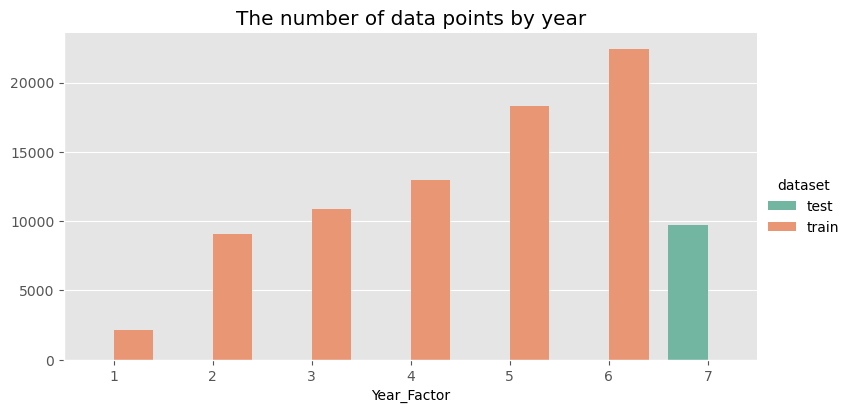

In [17]:
ax = sns.catplot(x='Year_Factor', 
                 y='id', 
                 data=df_all.groupby(['dataset','Year_Factor']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 kind='bar',
                 aspect=2,
                 height=4)\
.set(title="The number of data points by year", ylabel=None)
# encoded (morphed) value of original year

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">`train` set contains data points of 7 states, however, `test` doesn't have any data point from `State_6`.</div>

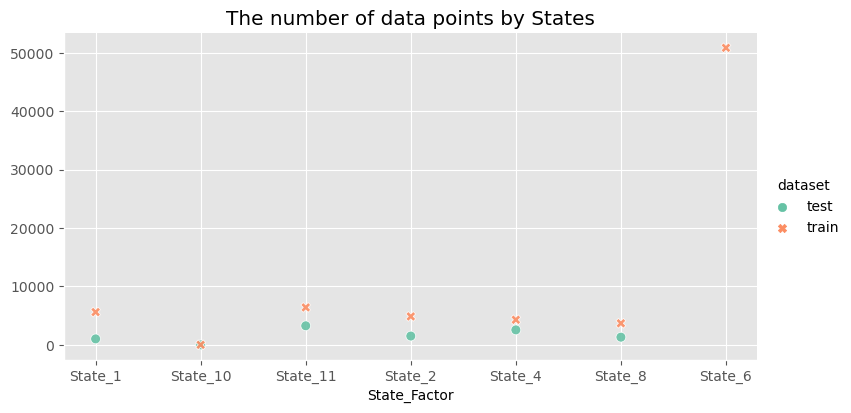

In [18]:
ax = sns.relplot(x='State_Factor', 
                 y='id', 
                 data=df_all.groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=2,
                 height=4,
                 s=50,
                 alpha=0.9
                )\
.set(title = "The number of data points by States",
    ylabel=None)

In [19]:
# df_test["state_factor"].unique()

Both residential and commercial buildings are present in both datasets. `train` data contains more residential buildings compared to `test` set which is due to the number of`State_6` buildings in `train` set which seems to add to the number. Apart from `State_6`, the number of commercial buildings are higher than the residential buildings and `State_10` only contains commercial buildings. The type of building and state could be important factors in determining `EUI`.

Text(0.5, 0, '')

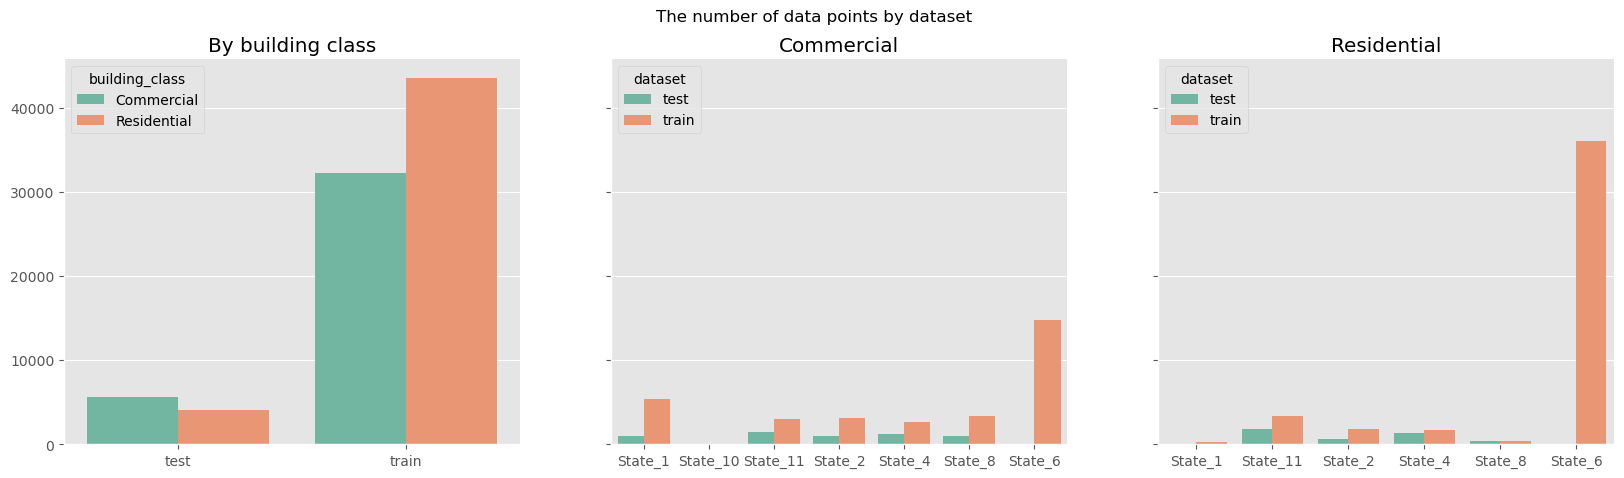

In [20]:
fig, ax = plt.subplots(1,3, figsize=(20,5), sharey=True)
fig.suptitle("The number of data points by dataset")

sns.barplot(x='dataset',
            y='id',
            data=df_all.groupby(['dataset','building_class']).agg({'id':'count'}).reset_index(),
            hue='building_class',
            ax=ax[0],
            ci=False)

for e, s in enumerate(df_all['building_class'].unique(),1):
    sns.barplot(x='State_Factor',
                y='id',
                data=df_all[df_all['building_class']==s].groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
                hue='dataset',
                ax=ax[e],
                ci=False)
    ax[e].set_title(s)
    ax[e].set_ylabel("")
    ax[e].set_xlabel("")

ax[0].set_title("By building class")
ax[0].set_ylabel("")
ax[0].set_xlabel("")

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">All facility types are present in both datasets. Almost 90% of residential `Multifamily_uncategorized` buildings and 50% of `Office_uncategorized` are in `State_6` of the training set. Not quite sure how `State_6` will affect the model learning and prediction.</div>

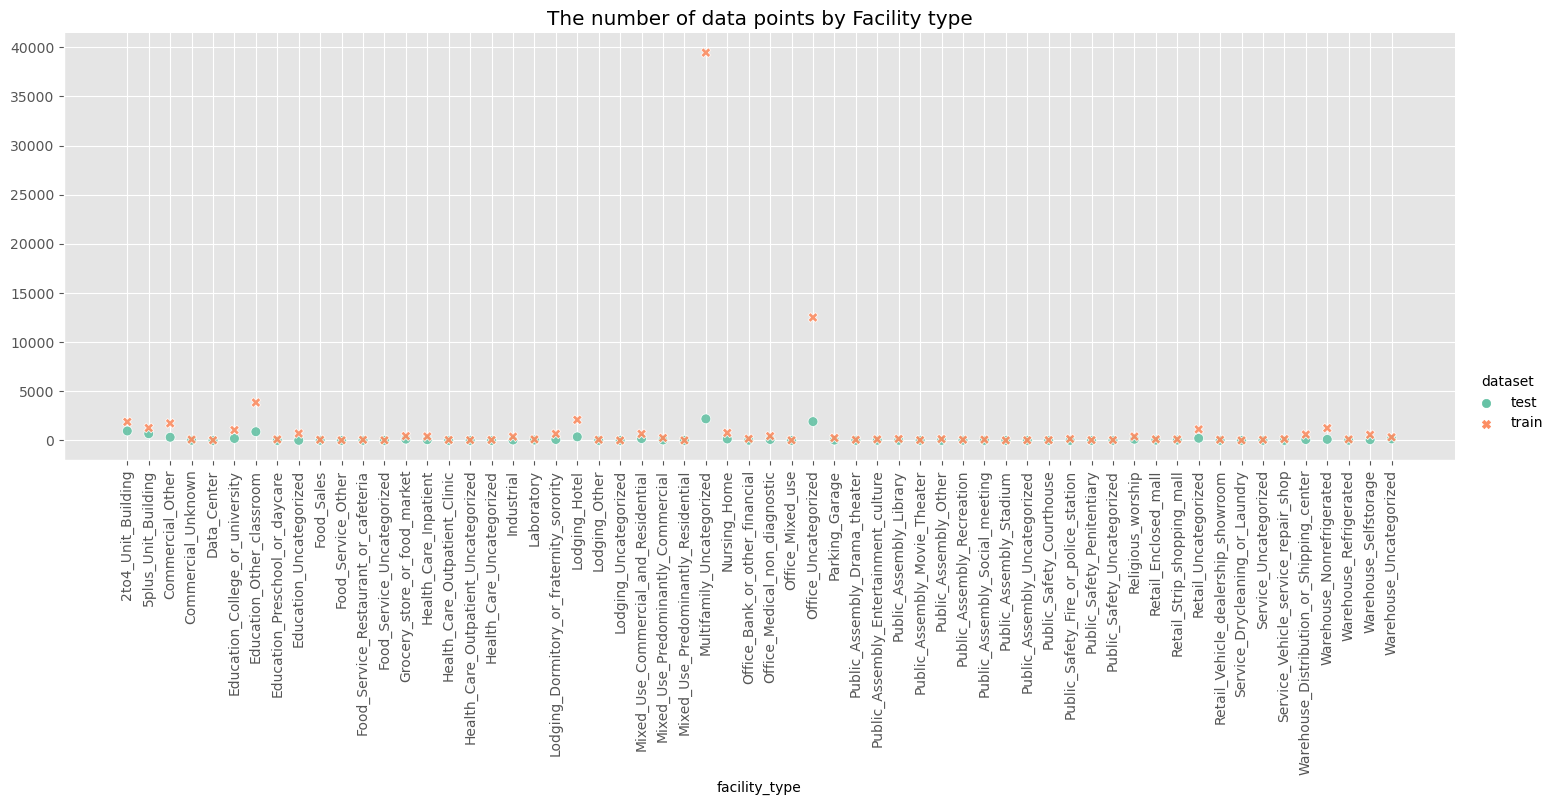

In [21]:
ax = sns.relplot(x='facility_type', 
                 y='id', 
                 data=df_all.groupby(['dataset','facility_type']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=3,
                 height=5,
                 s=50,
                 alpha=0.9
                )\
.set(title = "The number of data points by Facility type",
    ylabel=None)

ax.set_xticklabels(rotation=90) 
None

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">The oldest building was built in 1600 and the latest in 2016. The majority of the buildings were built since 1900. There were some 0 and null values. Not quite sure what 0 signifies.</div>

In [22]:
df_all['year_built'].value_counts().index.sort_values()

Float64Index([   0.0, 1600.0, 1649.0, 1732.0, 1756.0, 1789.0, 1799.0, 1800.0,
              1811.0, 1815.0,
              ...
              2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0,
              2015.0, 2016.0],
             dtype='float64', length=183)

Text(0.5, 0.98, 'The year built min: 1600.0, max: 2016.0')

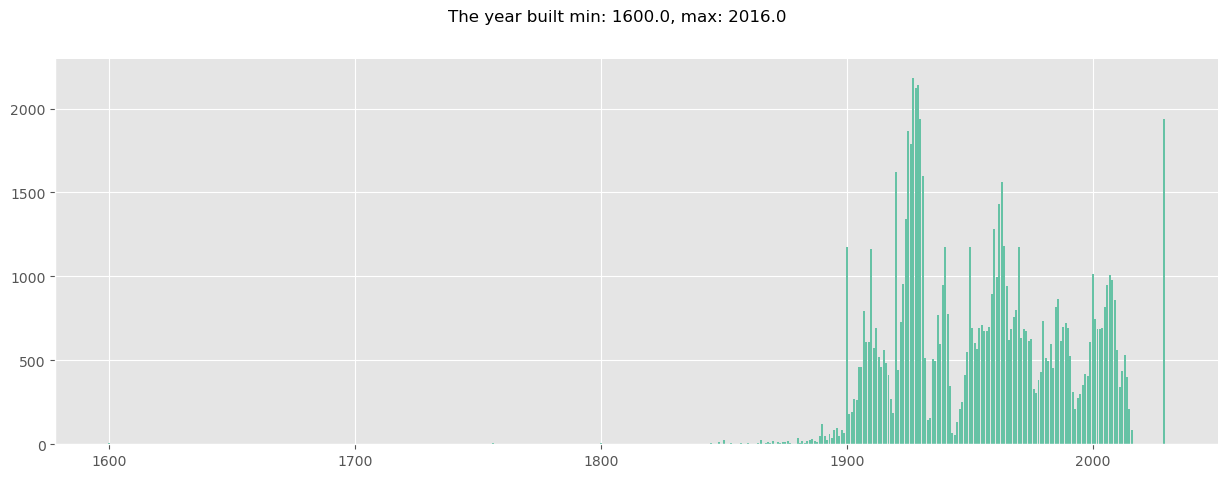

In [23]:
temp = df_all[['year_built']].fillna(2029).replace({0:2029}).astype('category').value_counts().reset_index().rename({0:'count'},axis=1)\
            .sort_values('year_built')
# temp['year_built'] = temp['year_built'].astype('category')
fig, ax = plt.subplots(figsize=(15,5))

ax=plt.bar(temp['year_built'],
           temp['count']
          )

fig.suptitle(f"The year built min: {min(temp['year_built'])}, max: {max(df_all['year_built'])}")

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">`train` set buildings have higher floor areas compared to `test` set buildings and small positive correlation between `floor_area` and `energy_star_rating` can be observable. </div>

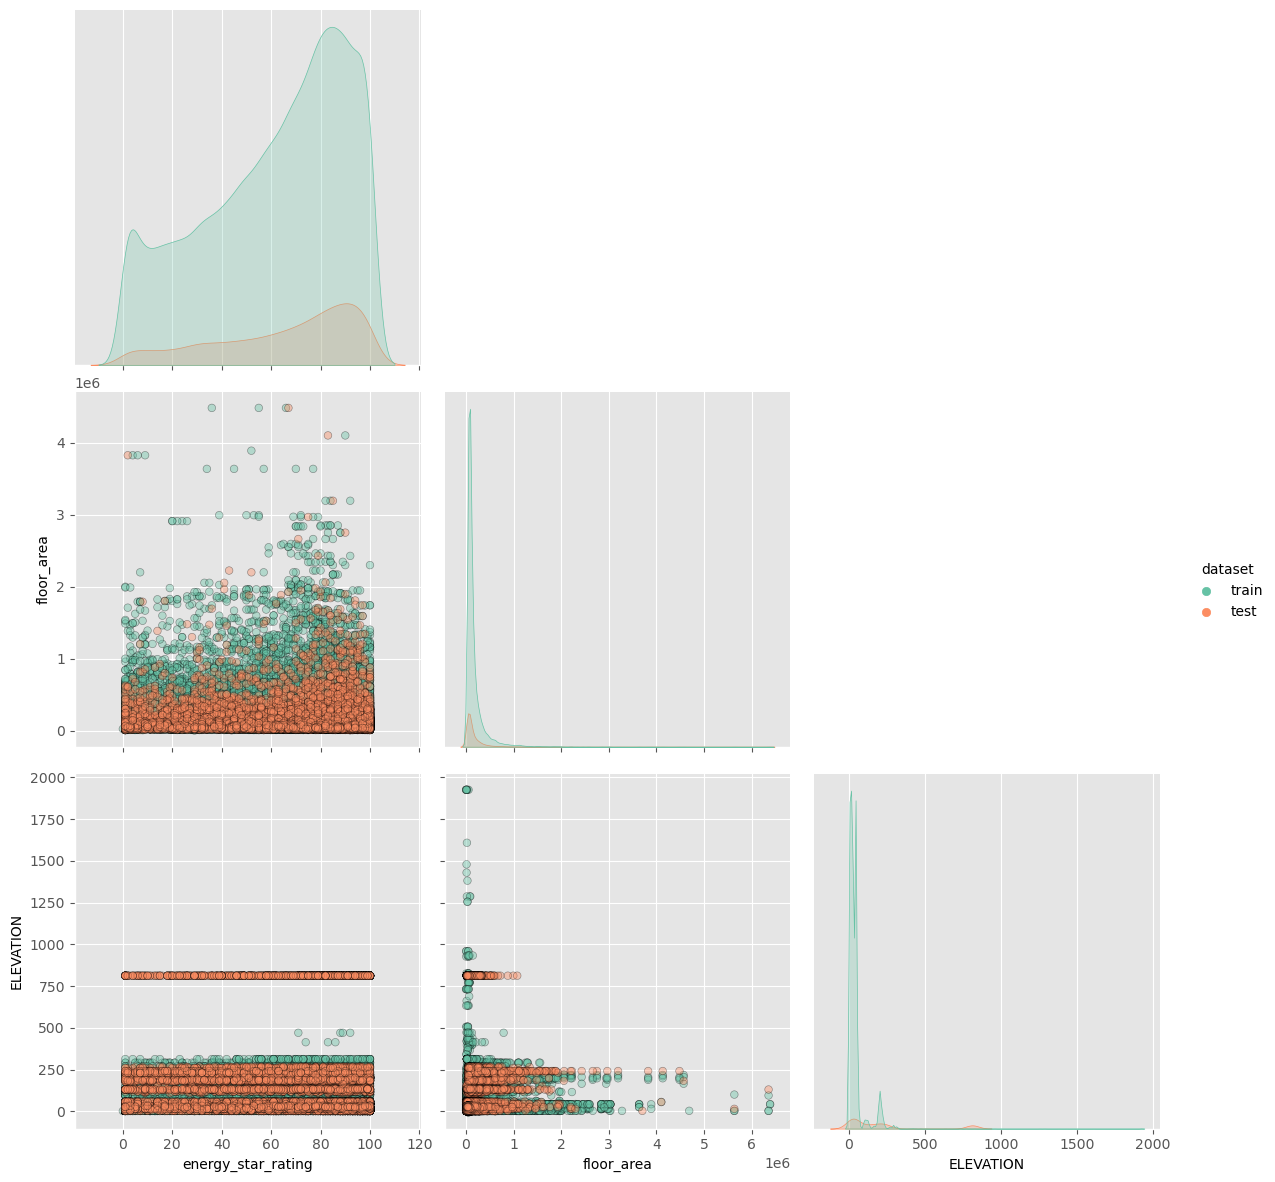

In [24]:
sns.pairplot(df_all,
            vars=['energy_star_rating','floor_area','ELEVATION'], 
            hue='dataset',
            height=4,
            plot_kws = {'alpha': 0.4, 's': 30, 'edgecolor': 'k'},
            corner=True
           )

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">According to the average temperature (`avg_temp`), if we list states from warmest to coldest: State 1, State 10, State 2, and State 8. The range of temperatures of State1, State 6,  State 11 and State 4 are higher compared to the other states. </div>

<Axes: xlabel='State_Factor', ylabel='avg_temp'>

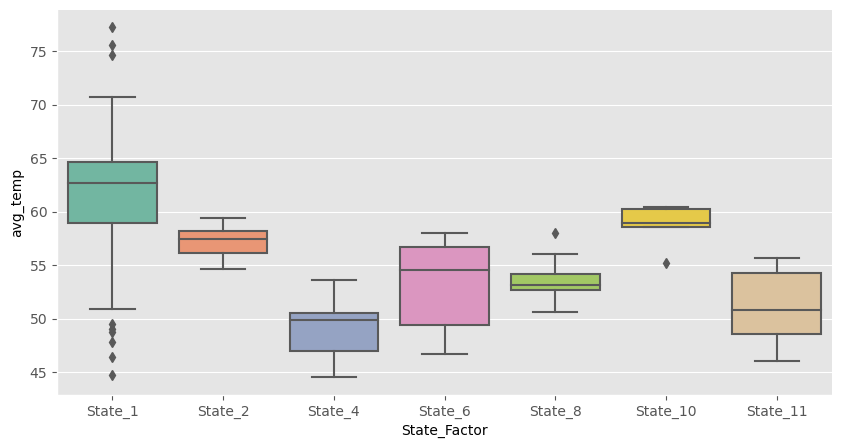

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=df_all[['avg_temp','State_Factor']].drop_duplicates(), y='avg_temp', x='State_Factor')


# any one categorical col (with low unique vals)

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">Each month has unique temperature values between 31 and 59 which means the values in temperature volumes are highly repeated for the data points.</div>

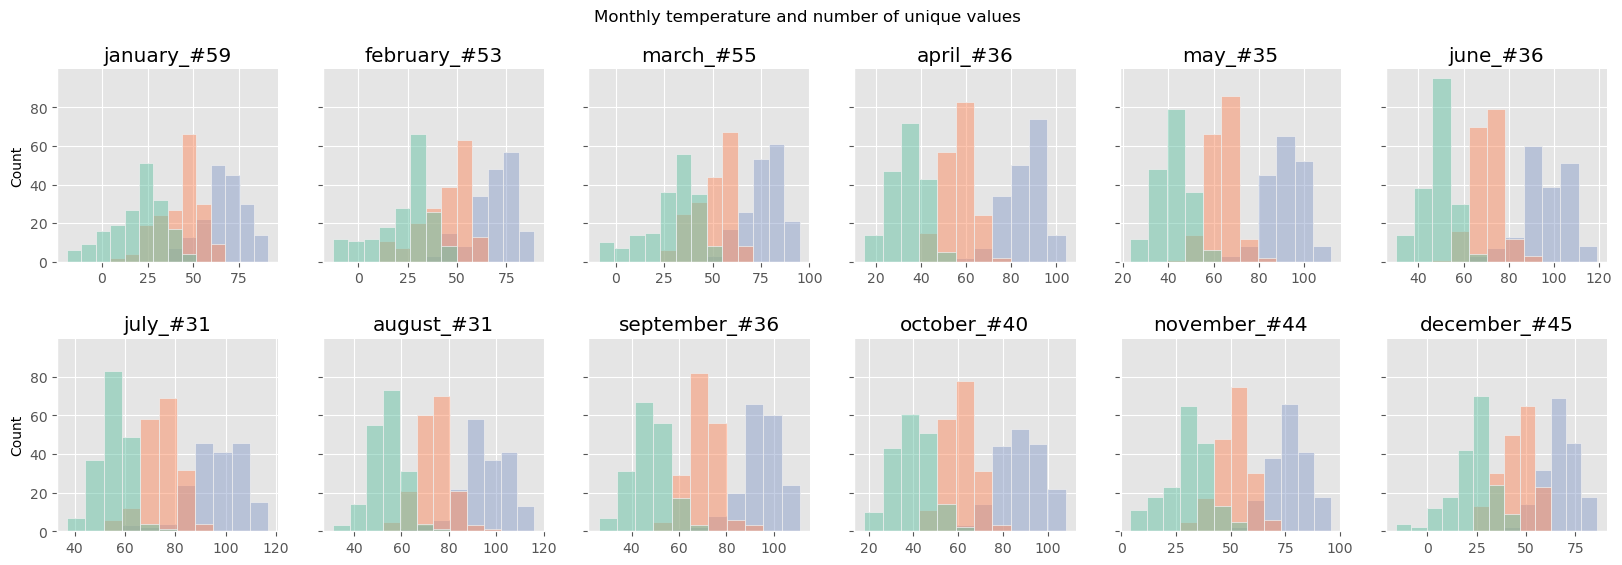

In [26]:
cols = [['january_min_temp', 'january_avg_temp', 'january_max_temp'],
        ['february_min_temp', 'february_avg_temp', 'february_max_temp'],
        ['march_min_temp', 'march_avg_temp', 'march_max_temp'], 
        ['april_min_temp','april_avg_temp', 'april_max_temp'], 
        ['may_min_temp', 'may_avg_temp','may_max_temp'], 
        ['june_min_temp', 'june_avg_temp', 'june_max_temp'],
        ['july_min_temp', 'july_avg_temp', 'july_max_temp'], 
        ['august_min_temp','august_avg_temp', 'august_max_temp'], 
        ['september_min_temp','september_avg_temp', 'september_max_temp'], 
        ['october_min_temp','october_avg_temp', 'october_max_temp'], 
        ['november_min_temp','november_avg_temp', 'november_max_temp'], 
        ['december_min_temp','december_avg_temp', 'december_max_temp']]
        
fig, ax = plt.subplots(2, 6, figsize=(20,6), sharey=True)
fig.suptitle("Monthly temperature and number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[0,e], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[1,e-6], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
        
plt.subplots_adjust(hspace=0.4)

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">Other weather related numerical columns also have few unique values.</div>

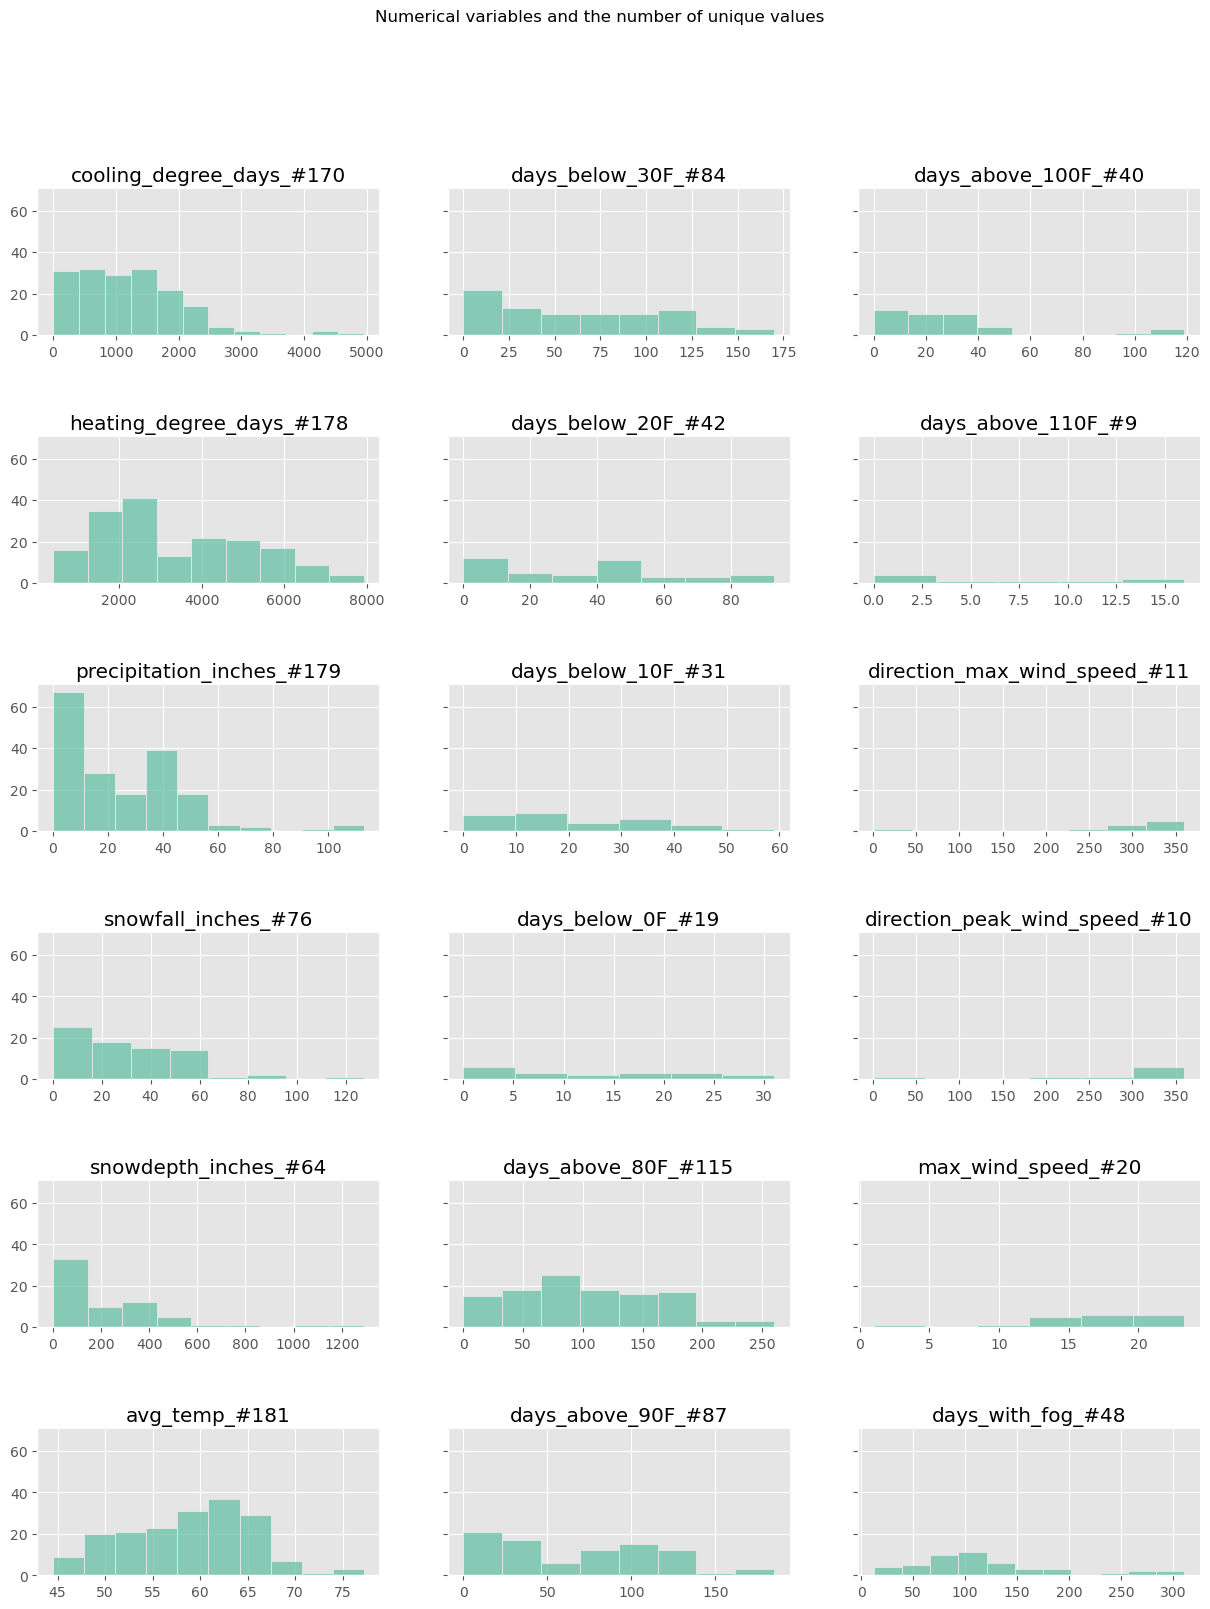

In [27]:
cols=['cooling_degree_days','heating_degree_days', 'precipitation_inches', 'snowfall_inches',
       'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F',
       'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
       'days_above_100F', 'days_above_110F', 'direction_max_wind_speed',
       'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']

fig, ax = plt.subplots(6,3, figsize=(15,18), sharey=True)
fig.suptitle("Numerical variables and the number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e,0], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
    elif (e>=6) & (e<=11):
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e-6,1], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e-12,2], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
        
plt.subplots_adjust(hspace=0.7)

In [28]:
# # larger datasets
# find groups in the columns
# elevation, floor areas (dimentions)
# temperature
# wind

Target Variable Exploration (EUI)

In [29]:
# the target is skewed  (log-normal)
# the target has many outliers
# decision:  log-transform,  IQR outlier treatment

# perform:  we do not perform any transformation

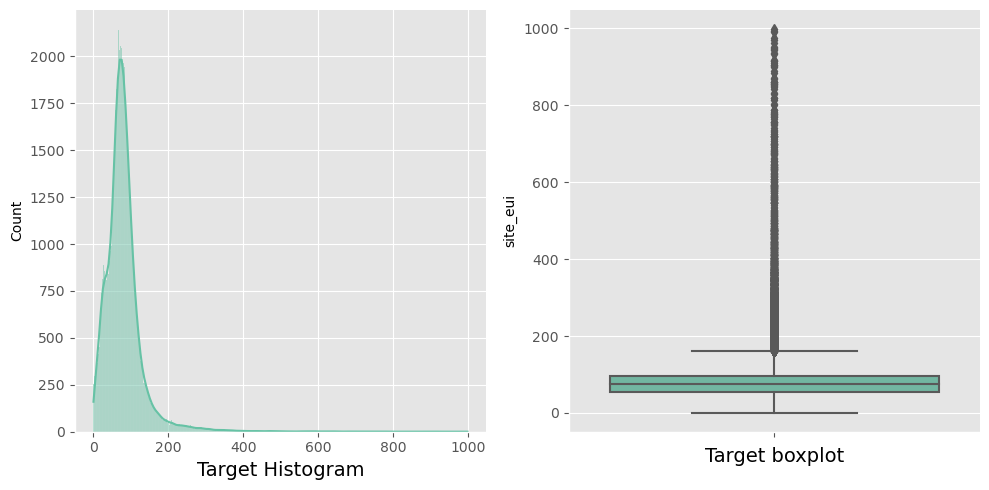

In [30]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
cp = sns.histplot(x=df_all['site_eui'], kde=True, palette='Set2')
ax1.set_xlabel('Target Histogram', fontsize=14)
ax2 = plt.subplot(1,2,2)
sns.boxplot(y=df_all['site_eui'], palette='Set2')
ax2.set_xlabel('Target boxplot', fontsize=14)
plt.tight_layout()

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">State 2 and 4 have slightly higher EUI and State 11 and 8 have lower EUI level.</div>

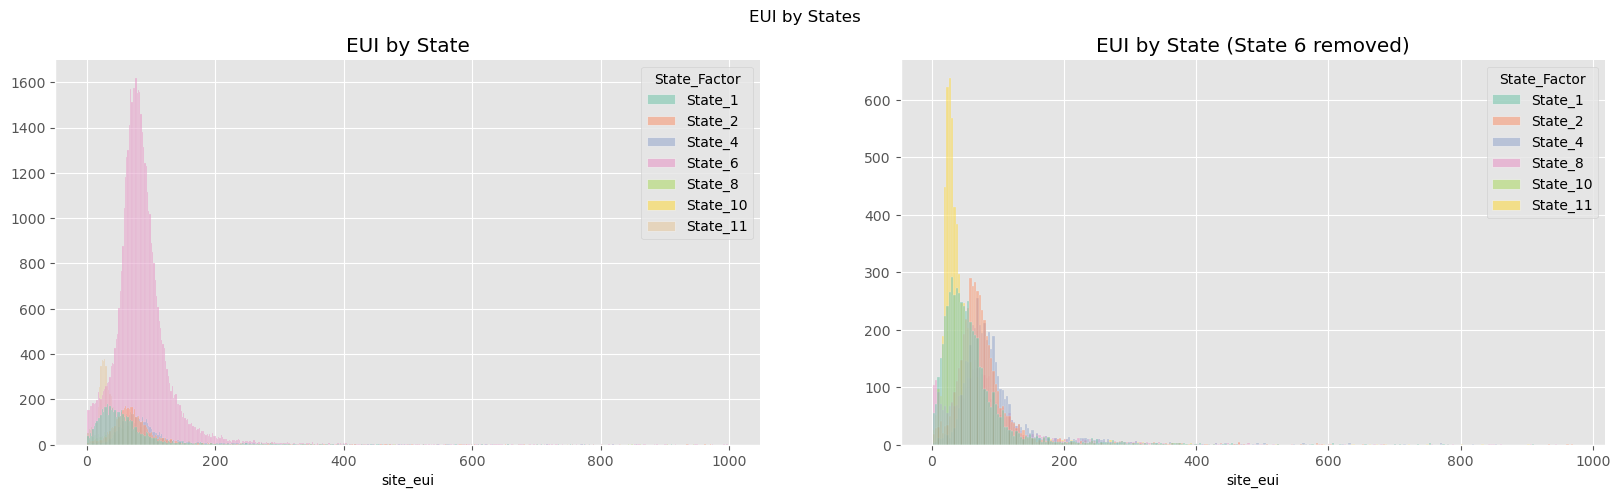

In [31]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
fig.suptitle("EUI by States")

sns.histplot(df_all, x='site_eui',hue='State_Factor', ax=ax[0])\
.set(title='EUI by State', ylabel=None)

sns.histplot(df_all[df_all['State_Factor']!='State_6'], x='site_eui', hue='State_Factor', ax=ax[1])\
.set(title='EUI by State (State 6 removed)', ylabel=None);

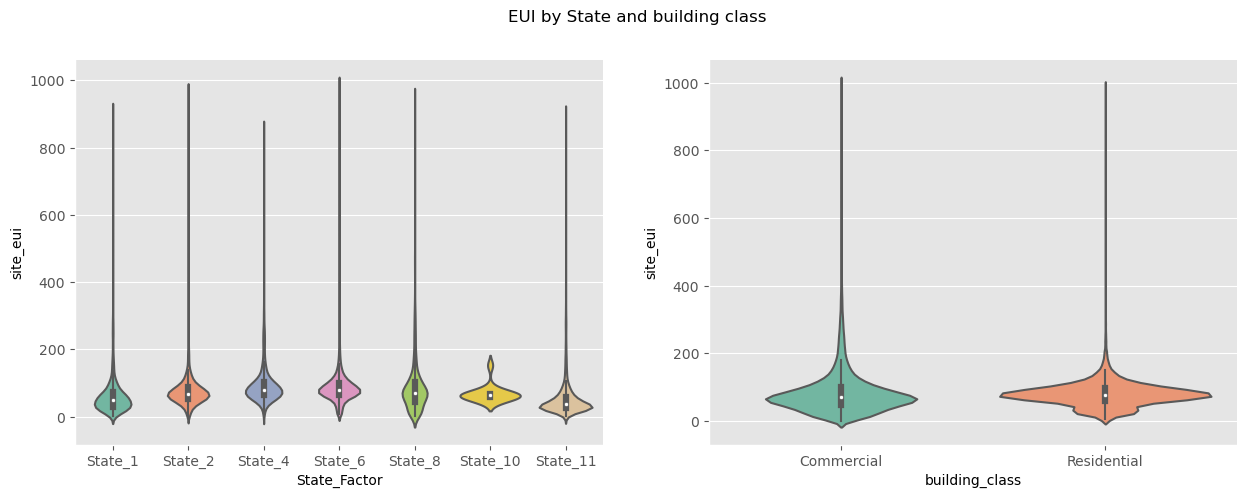

In [32]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("EUI by State and building class")

sns.violinplot(data=df_all, y='site_eui', x='State_Factor', ax=ax[0])
sns.violinplot(data=df_all, y='site_eui', x='building_class', ax=ax[1]);

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">Labs and Data Centers have higher EUI compared to the other types of buildings. Grocery stores, Health Care Inpatient, Health Care Uncategorized, Health Care Outpatient, and Food service, restaurants have higher range of EUI. It could be the essential services must operate for longer hours, therefore, have higher EUI.</div>

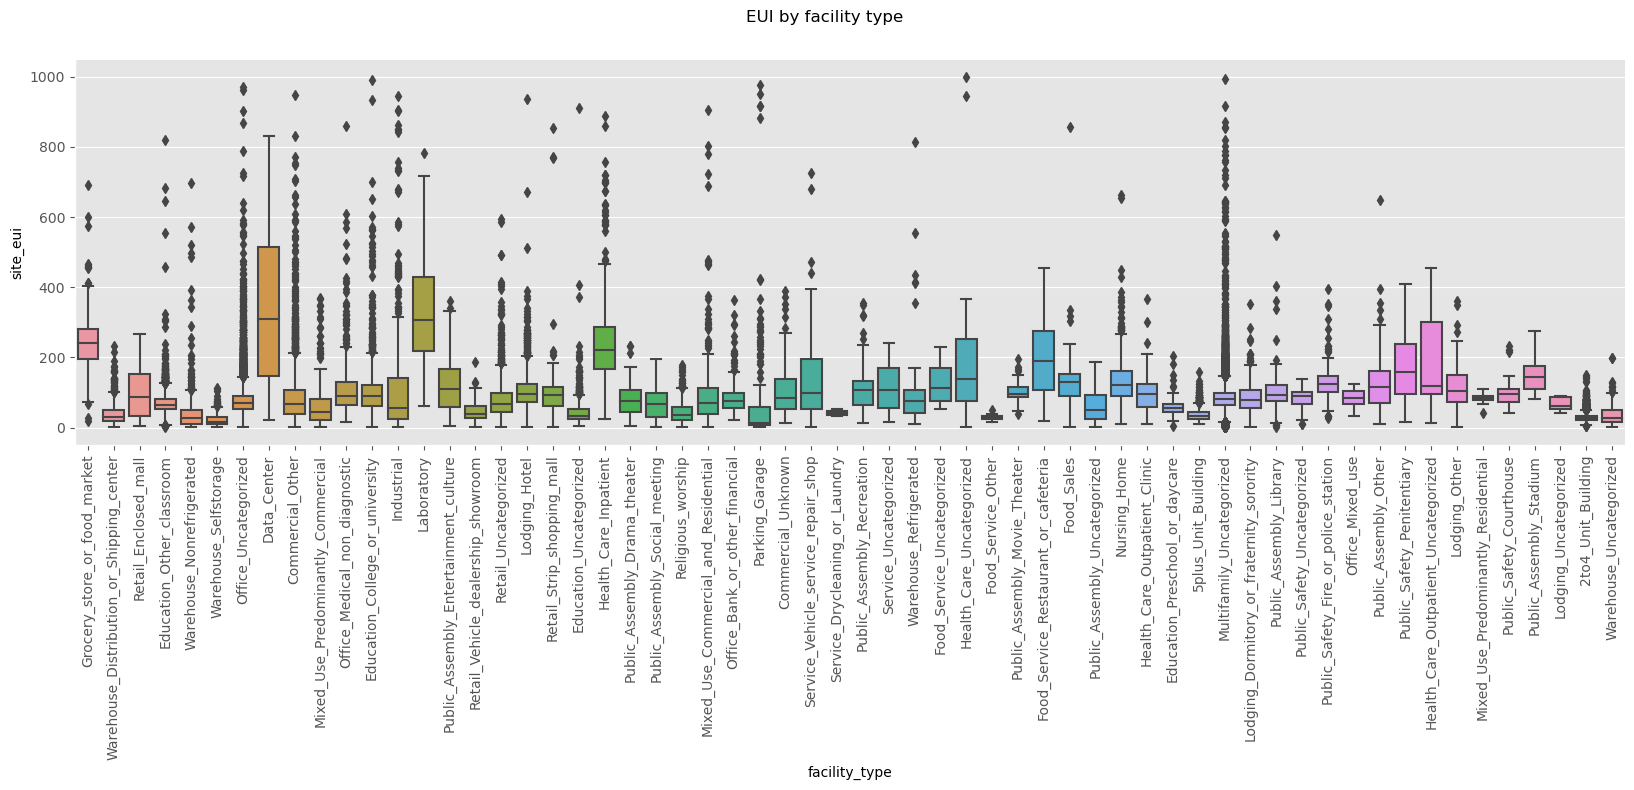

In [33]:
fig, ax = plt.subplots(figsize=(20,5))
fig.suptitle("EUI by facility type")
ax=sns.boxplot(data=df_all, y='site_eui', x='facility_type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">`floor_area` could have positive relationship with `EUI`. The younger buildings tend to have higher `EUI` which could be because building height and size have increased over the years. It looks like the Higher the `energy_star_rating` is, the lower the `EUI` becomes.</div>

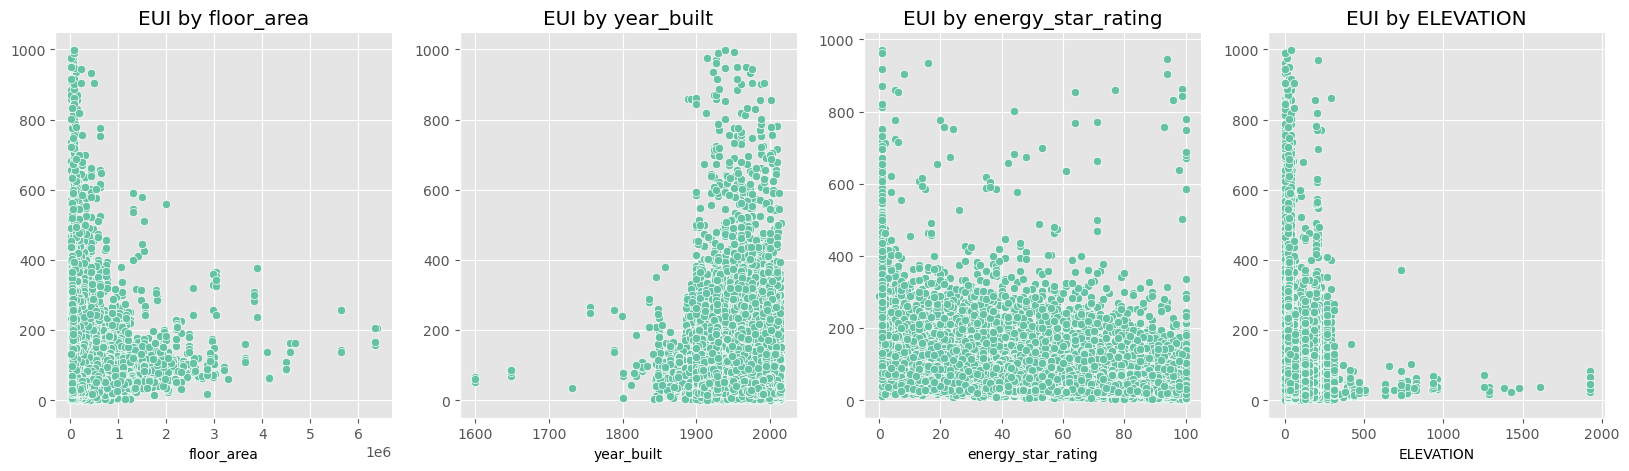

In [34]:
fig, ax = plt.subplots(1,4, figsize=(20,5))

for e, col in enumerate(['floor_area', 'year_built', 'energy_star_rating', 'ELEVATION']):
    if col =='year_built':
        sns.scatterplot(data=df_all[(df_all['year_built']!=0) & (df_all['year_built'].notna())], 
                        x=col, y='site_eui', ax=ax[e]).set(title='EUI by '+ col, ylabel=None)
    else:
        sns.scatterplot(data=df_all, x=col, y='site_eui', ax=ax[e]).set(title='EUI by '+ col, ylabel=None);

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">The most data points are in lower number of `cooling_degree_days` and higher number of`heating_degree_days`. The majority of the datapoints are also in the lower levels of `snowfall_inches` and `snowdepth_inches`. `direction_max_wind_speed`, `direction_peak_wind_speed`, `max_wind_speed`, and `days_with_fog` columns have the `NA` values of over 50%. No relationship between `EUI` and the weather related numerica columns can be observed from the plot.</div>

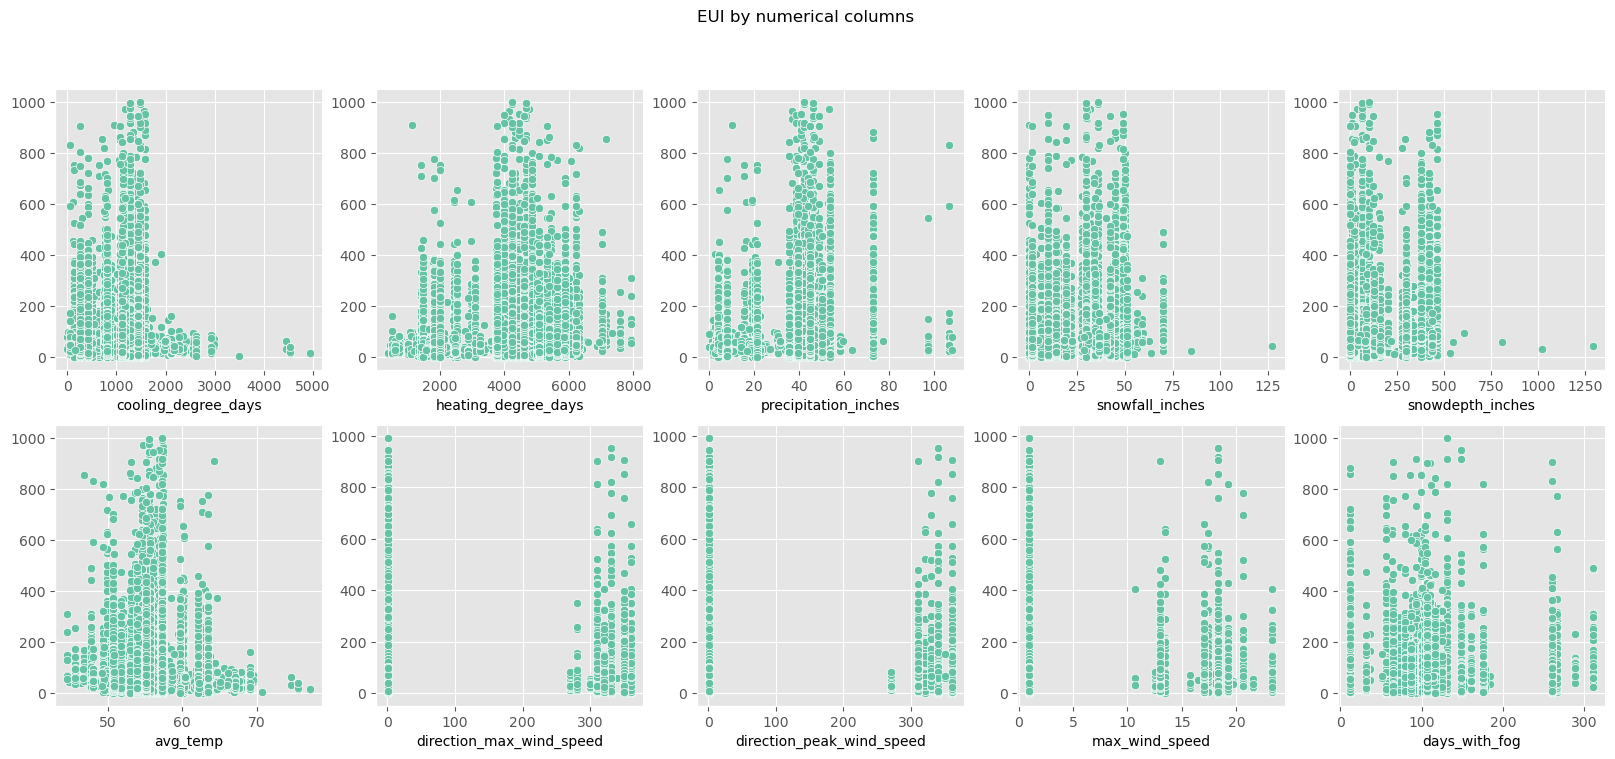

In [35]:
cols=[['cooling_degree_days','heating_degree_days', 'precipitation_inches', 
      'snowfall_inches','snowdepth_inches'], 
      ['avg_temp', 
      'direction_max_wind_speed','direction_peak_wind_speed', 'max_wind_speed', 
      'days_with_fog']]

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('EUI by numerical columns')

for e1, l in enumerate(cols):
    for e2, col in enumerate(l):
        sns.scatterplot(data=df_all, 
                        x=col, y='site_eui', ax=ax[e1, e2]).set(ylabel=None);

<B>💡 Observations:</B>

- Categorical variables such as `State_Factor`, `building_class` and `facility_type` might have some correlation with `EUI`.
- `State_6` is not present in `test` set. State 6 removed training data should be tested.
- `floor_area`, `energe_star_rating` should be included in the modelling to be tested.
- From the plots, it's difficult to observe direct (linear) relationship between `EUI` and weather related variables. However, this doesn't deny non-linear relationships among the variables.
- Variables with more than 50% `NA` values should not be imputed (in my opinion) and better to be not included in the training set.
- Weather variables have few unique values repeated throughout the datapoints. Not sure how this duplicated values might affect the modeling and prediction.

<B> Preprocessing </B><br>
We will suppose that two  if two buildings have the same values for these features;   
they are the same building, in other words groupby_cols = (building_id)

Removing duplicates by clubbing similar building data

In [36]:
# null values,
# weather data points have a lot of repetition
# categories encoded

In [37]:
groupby_cols = ['State_Factor','building_class','facility_type','floor_area','year_built']
df_all = df_all.sort_values(by=groupby_cols+['Year_Factor']).reset_index(drop=True)

In [38]:
df_all.loc[:,df_all.dtypes=='object'].columns

Index(['State_Factor', 'building_class', 'facility_type', 'dataset'], dtype='object')


<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    Null imputation for categorical values: <b>KNN Imputing</b>
</div>

In [39]:
df_all_one_hot = df_all.copy()

cats = ['State_Factor', 'facility_type', 'building_class']
for col in cats:
    dummies = pd.get_dummies(df_all_one_hot[col], dummy_na=False)
    for ohe_col in dummies:
        df_all_one_hot[f'ohe_{col}_{ohe_col}'] = dummies[ohe_col]

In [40]:
df_all_one_hot

Year_Factor State_Factor building_class              facility_type  \
0                3      State_1     Commercial           Commercial_Other   
1                4      State_1     Commercial           Commercial_Other   
2                5      State_1     Commercial           Commercial_Other   
3                7      State_1     Commercial           Commercial_Other   
4                3      State_1     Commercial           Commercial_Other   
...            ...          ...            ...                        ...   
85457            7      State_8    Residential  Multifamily_Uncategorized   
85458            6      State_8    Residential  Multifamily_Uncategorized   
85459            7      State_8    Residential  Multifamily_Uncategorized   
85460            6      State_8    Residential  Multifamily_Uncategorized   
85461            7      State_8    Residential  Multifamily_Uncategorized   

       floor_area  year_built  energy_star_rating  ELEVATION  \
0         10149.0      1931.0                 NaN       45.7   
1         10149.0      1931.0                 NaN      120.4   
2         10149.0      1931.0                 NaN       59.1   
3         10149.0      1931.0                 NaN       59.1   
4         10755.0      1937.0                 NaN        9.1   
...           ...         ...                 ...        ...   
85457    900000.0      1960.0                90.0      130.8   
85458   1179072.0      1959.0                96.0        3.0   
85459   1179072.0      1959.0                92.0      130.8   
85460   1195034.0      1964.0                75.0        3.0   
85461   1195034.0      1964.0                77.0      130.8   

       january_min_temp  january_avg_temp  january_max_temp  \
0                    26         44.516129                64   
1                    41         55.096774                73   
2                    29         51.387097                77   
3                    38         50.596774                64   
4                    22         44.790323                65   
...                 ...               ...               ...   
85457                 2         33.435484                61   
85458                 8         29.827586                62   
85459                 2         33.435484                61   
85460                 8         29.827586                62   
85461                 2         33.435484                61   

       february_min_temp  february_avg_temp  february_max_temp  \
0                     30          49.392857                 69   
1                     42          54.875000                 71   
2                     36          56.803571                 75   
3                     40          54.482143                 66   
4                     25          47.892857                 71   
...                  ...                ...                ...   
85457                 16          37.660714                 73   
85458                  4          33.896552                 62   
85459                 16          37.660714                 73   
85460                  4          33.896552                 62   
85461                 16          37.660714                 73   

       march_min_temp  march_avg_temp  march_max_temp  april_min_temp  \
0                  37       55.967742              77              40   
1                  47       59.032258              76              47   
2                  40       61.435484              85              41   
3                  42       56.935484              77              45   
4                  32       53.112903              79              34   
...               ...             ...             ...             ...   
85457               8       35.935484              69              28   
85458              24       45.967742              79              18   
85459               8       35.935484              69              28   
85460              24       45.96

In [41]:
# This takes 1 hr, hence, unpickle the df1 and carry on with knn_imputing = False

knn_imputing = False
target='site_eui'

if knn_imputing:
    imputer = KNNImputer(n_neighbors=7)
    tmp = df_all[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
    df = df_all.drop(tmp.columns, axis=1)
    df1 = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
    tmp.to_csv('../data/imputer_tmp.csv', index=False)
    df1.to_csv('../data/imputer_df1.csv', index=False)
    joblib.dump(imputer, 'knn_imputer.pkl')

else:
    df1 = pd.read_csv('../data/imputer_df1.csv')
    tmp = df_all[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
    df_all = df_all.drop(tmp.columns, axis=1)
    for col in tmp.columns:
        df_all[col]=tmp[col]
    for col in df1.columns:
        df_all[col] = df1[col]


# df1: no null values
# tmp: seperated columns
#     df1 + tmp  => final df



# null points  => neighbours (most gets imputed)

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    <b>Target encoding</b> for categorical columns.  
Target encoding is the process of replacing a categorical value with the mean of the target variable. Any non-categorical columns are automatically dropped by the target encoder model.

Note: You can also use target encoding to convert categorical columns to numeric. 

> “features are replaced with a blend of posterior probability of the target given particular categorical value and the prior probability of the target over all the training data.”

[Target Encoding Vs. One-hot Encoding with Simple Examples](https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64)
<div>

In [42]:
df_all_te = df_all.copy()

cats = ['State_Factor', 'building_class', 'facility_type']
for col in cats:
    encoder = TargetEncoder()
    df_all_te[f'te_{col}'] = encoder.fit_transform(df_all_te[col], df_all_te[target])

<b>Feature Engineering</b>

<b>Weather based features</b>

We will extract new weather statistics from the building location weather features

In [43]:
# extract new weather statistics from the building location weather features
temp = [col for col in df_all_te.columns if 'temp' in col]

df_all_te['min_temp'] = df_all_te[temp].min(axis=1)
df_all_te['max_temp'] = df_all_te[temp].max(axis=1)
df_all_te['avg_temp'] = df_all_te[temp].mean(axis=1)
df_all_te['std_temp'] = df_all_te[temp].std(axis=1)
df_all_te['skew_temp'] = df_all_te[temp].skew(axis=1)

# by seasons
temp = pd.Series([col for col in df_all_te.columns if 'temp' in col])

winter_temp = temp[temp.apply(lambda x: ('january' in x or 'february' in x or 'december' in x))].values
spring_temp = temp[temp.apply(lambda x: ('march' in x or 'april' in x or 'may' in x))].values
summer_temp = temp[temp.apply(lambda x: ('june' in x or 'july' in x or 'august' in x))].values
autumn_temp = temp[temp.apply(lambda x: ('september' in x or 'october' in x or 'november' in x))].values

### winter
df_all_te['min_winter_temp'] = df_all_te[winter_temp].min(axis=1)
df_all_te['max_winter_temp'] = df_all_te[winter_temp].max(axis=1)
df_all_te['avg_winter_temp'] = df_all_te[winter_temp].mean(axis=1)
df_all_te['std_winter_temp'] = df_all_te[winter_temp].std(axis=1)
df_all_te['skew_winter_temp'] = df_all_te[winter_temp].skew(axis=1)
### spring
df_all_te['min_spring_temp'] = df_all_te[spring_temp].min(axis=1)
df_all_te['max_spring_temp'] = df_all_te[spring_temp].max(axis=1)
df_all_te['avg_spring_temp'] = df_all_te[spring_temp].mean(axis=1)
df_all_te['std_spring_temp'] = df_all_te[spring_temp].std(axis=1)
df_all_te['skew_spring_temp'] = df_all_te[spring_temp].skew(axis=1)
### summer
df_all_te['min_summer_temp'] = df_all_te[summer_temp].min(axis=1)
df_all_te['max_summer_temp'] = df_all_te[summer_temp].max(axis=1)
df_all_te['avg_summer_temp'] = df_all_te[summer_temp].mean(axis=1)
df_all_te['std_summer_temp'] = df_all_te[summer_temp].max(axis=1)
df_all_te['skew_summer_temp'] = df_all_te[summer_temp].max(axis=1)
## autumn
df_all_te['min_autumn_temp'] = df_all_te[autumn_temp].min(axis=1)
df_all_te['max_autumn_temp'] = df_all_te[autumn_temp].max(axis=1)
df_all_te['avg_autumn_temp'] = df_all_te[autumn_temp].mean(axis=1)
df_all_te['std_autumn_temp'] = df_all_te[autumn_temp].std(axis=1)
df_all_te['skew_autumn_temp'] = df_all_te[autumn_temp].skew(axis=1)

In [44]:
df_all_te['month_cooling_degree_days'] = df_all_te['cooling_degree_days']/12
df_all_te['month_heating_degree_days'] = df_all_te['heating_degree_days']/12

In [45]:
df_all_te[temp]

january_min_temp  january_avg_temp  january_max_temp  \
0                  26.0         44.516129              64.0   
1                  41.0         55.096774              73.0   
2                  29.0         51.387097              77.0   
3                  38.0         50.596774              64.0   
4                  22.0         44.790323              65.0   
...                 ...               ...               ...   
85457               2.0         33.435484              61.0   
85458               8.0         29.827586              62.0   
85459               2.0         33.435484              61.0   
85460               8.0         29.827586              62.0   
85461               2.0         33.435484              61.0   

       february_min_temp  february_avg_temp  february_max_temp  \
0                   30.0          49.392857               69.0   
1                   42.0          54.875000               71.0   
2                   36.0          56.803571               75.0   
3                   40.0          54.482143               66.0   
4                   25.0          47.892857               71.0   
...                  ...                ...                ...   
85457               16.0          37.660714               73.0   
85458                4.0          33.896552               62.0   
85459               16.0          37.660714               73.0   
85460                4.0          33.896552               62.0   
85461               16.0          37.660714               73.0   

       march_min_temp  march_avg_temp  march_max_temp  april_min_temp  \
0                37.0       55.967742            77.0            40.0   
1                47.0       59.032258            76.0            47.0   
2                40.0       61.435484            85.0            41.0   
3                42.0       56.935484            77.0            45.0   
4                32.0       53.112903            79.0            34.0   
...               ...             ...             ...             ...   
85457             8.0       35.935484            69.0            28.0   
85458            24.0       45.967742            79.0            18.0   
85459             8.0       35.935484            69.0            28.0   
85460            24.0       45.967742            79.0            18.0   
85461             8.0       35.935484            69.0            28.0   

       april_avg_temp  april_max_temp  may_min_temp  may_avg_temp  \
0           61.783333            90.0          45.0     65.129032   
1           60.100000            90.0          51.0     63.483871   
2           60.966667            91.0          45.0     62.887097   
3           58.450000            78.0          49.0     60.903226   
4           58.866667            87.0          35.0     62.096774   
...               ...             ...           ...           ...   
85457       54.800000            85.0          38.0     59.096774   
85458       49.931034            81.0          37.0     59.161290   
85459       54.800000            85.0          38.0     59.096774   
85460       49.931034            81.0          37.0     59.161290   
85461       54.800000            85.0          38.0     59.096774   

       may_max_temp  june_min_temp  june_avg_temp  june_max_temp  \
0              91.0           52.0      70.016667          104.0   
1              92.0           52.0      64.250000           87.0   
2              90.0           55.0      72.983333          106.0   
3              87.0           51.0      63.150000           97.0   
4              91.0           44.0      66.283333           99.0   
...             ...            ...            ...            ...   
85457          92.0           40.0      68.689655           91.0   
85458          89.0           45.0      70.465517           90.0   
85459          92.0           40.0      68.689655           91.0   
85460          89.0           45.0      70.465517           90.0   
854

In [46]:
df_all_te['cooling_degree_days']

0         826.0
1         497.0
2        1319.0
3         342.0
4         303.0
          ...  
85457     866.0
85458    1114.0
85459     866.0
85460    1114.0
85461     866.0
Name: cooling_degree_days, Length: 85462, dtype: float64

In [47]:
df_all_te[['min_winter_temp', 'max_winter_temp', 'avg_winter_temp', 'std_winter_temp', 'skew_winter_temp',
           'min_spring_temp', 'max_spring_temp', 'avg_spring_temp', 'std_spring_temp', 'skew_spring_temp',
           'min_summer_temp', 'max_summer_temp', 'avg_summer_temp', 'std_summer_temp', 'skew_summer_temp',
           'min_autumn_temp', 'max_autumn_temp', 'avg_autumn_temp', 'std_autumn_temp', 'skew_autumn_temp']]

min_winter_temp  max_winter_temp  avg_winter_temp  std_winter_temp  \
0                 24.0             69.0        46.699565        17.630529   
1                 41.0             73.0        55.862455        12.779553   
2                 28.0             77.0        52.196813        18.727631   
3                 38.0             66.0        52.107335        11.619161   
4                 16.0             71.0        44.780210        20.572244   
...                ...              ...              ...              ...   
85457              2.0             73.0        34.781059        25.280345   
85458              4.0             62.0        33.872574        22.974302   
85459              2.0             73.0        34.781059        25.280345   
85460              4.0             62.0        33.872574        22.974302   
85461              2.0             73.0        34.781059        25.280345   

       skew_winter_temp  min_spring_temp  max_spring_temp  avg_spring_temp  \
0              0.021018             37.0             91.0        62.542234   
1              0.081583             47.0             92.0        65.068459   
2              0.005259             40.0             91.0        64.143250   
3             -0.034349             42.0             87.0        61.587634   
4             -0.084189             32.0             91.0        59.119594   
...                 ...              ...              ...              ...   
85457          0.107184              8.0             92.0        52.203584   
85458          0.053637             18.0             89.0        53.673341   
85459          0.107184              8.0             92.0        52.203584   
85460          0.053637             18.0             89.0        53.673341   
85461          0.107184              8.0             92.0        52.203584   

       std_spring_temp  skew_spring_temp  min_summer_temp  max_summer_temp  \
0            20.284168          0.250054             52.0            104.0   
1            17.251378          0.670141             52.0             90.0   
2            20.398627          0.230872             55.0            106.0   
3            15.818993          0.417654             51.0             97.0   
4            22.864101          0.160184             44.0             99.0   
...                ...               ...              ...              ...   
85457        27.390463         -0.033897             40.0             91.0   
85458        25.423297          0.041405             45.0             96.0   
85459        27.390463         -0.033897             40.0             91.0   
85460        25.423297          0.041405             45.0             96.0   
85461        27.390463         -0.033897             40.0             91.0   

       avg_summer_temp  std_summer_temp  skew_summer_temp  min_autumn_temp  \
0            74.858483            104.0             104.0             36.0   
1            68.574373             90.0              90.0             46.0   
2            78.697073            106.0             106.0             29.0   
3            68.918100             97.0              97.0             43.0   
4            68.673059             99.0              99.0             31.0   
...                ...              ...               ...              ...   
85457        69.992399             91.0              91.0             17.0   
85458        73.363851             96.0              96.0             20.0   
85459        69.992399             91.0              91.0             17.0   
85460        73.363851             96.0              96.0             20.0   
85461        69.992399             91.0              91.0             17.0   

       max_autumn_temp  avg_autumn_temp  std_autumn_temp  skew_autumn_temp  
0                 98.0        63.361111        20.462133          0.360253  
1                 95.0        67.521625        15.342943          0.494753  
2                105.0        67.003405 

<b>Buildig based feature:</b>

we will extract building statistics

In [48]:
# total area
df_all_te['building_area'] = df_all_te['floor_area'] * df_all_te['ELEVATION']
# rating energy by floor
df_all_te['floor_energy_star_rating'] = df_all_te['energy_star_rating']/df_all_te['ELEVATION']

In [49]:
df_all_te[["floor_area", "ELEVATION", "energy_star_rating", "floor_energy_star_rating", "building_area"]]

floor_area  ELEVATION  energy_star_rating  floor_energy_star_rating  \
0         10149.0       45.7           38.428571                  0.840888   
1         10149.0      120.4           43.571429                  0.361889   
2         10149.0       59.1           37.571429                  0.635726   
3         10149.0       59.1           60.285714                  1.020063   
4         10755.0        9.1           45.571429                  5.007849   
...           ...        ...                 ...                       ...   
85457    900000.0      130.8           90.000000                  0.688073   
85458   1179072.0        3.0           96.000000                 32.000000   
85459   1179072.0      130.8           92.000000                  0.703364   
85460   1195034.0        3.0           75.000000                 25.000000   
85461   1195034.0      130.8           77.000000                  0.588685   

       building_area  
0           463809.3  
1          1221939.6  
2           599805.9  
3           599805.9  
4            97870.5  
...              ...  
85457    117720000.0  
85458      3537216.0  
85459    154222617.6  
85460      3585102.0  
85461    156310447.2  

[85462 rows x 5 columns]

Checking target variable transformation

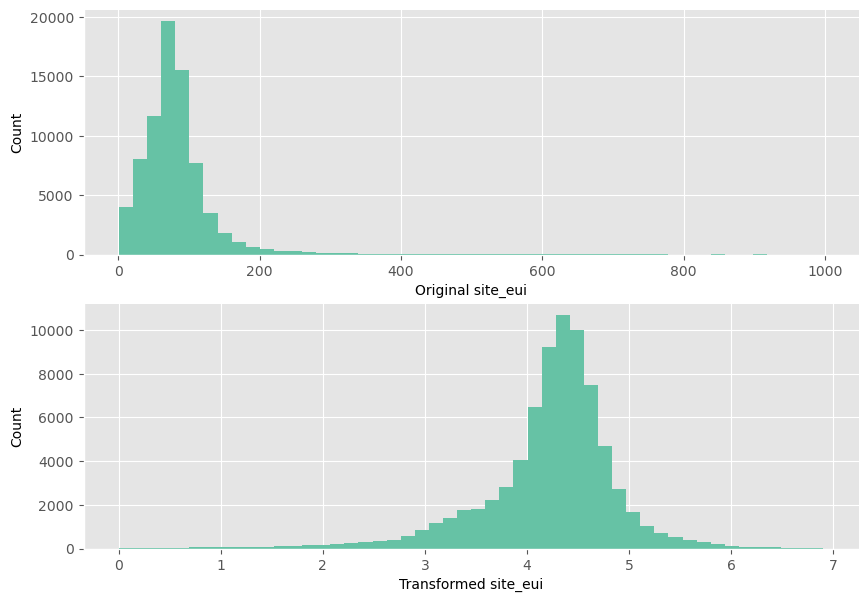

In [50]:
target = 'site_eui'
plt.figure(figsize=(10,7))
# plot the original variable vs sale price    
plt.subplot(2, 1, 1)
train[target].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Original ' + target)

# plot transformed variable vs sale price
plt.subplot(2, 1, 2)
np.log(train[target]).hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Transformed ' + target);

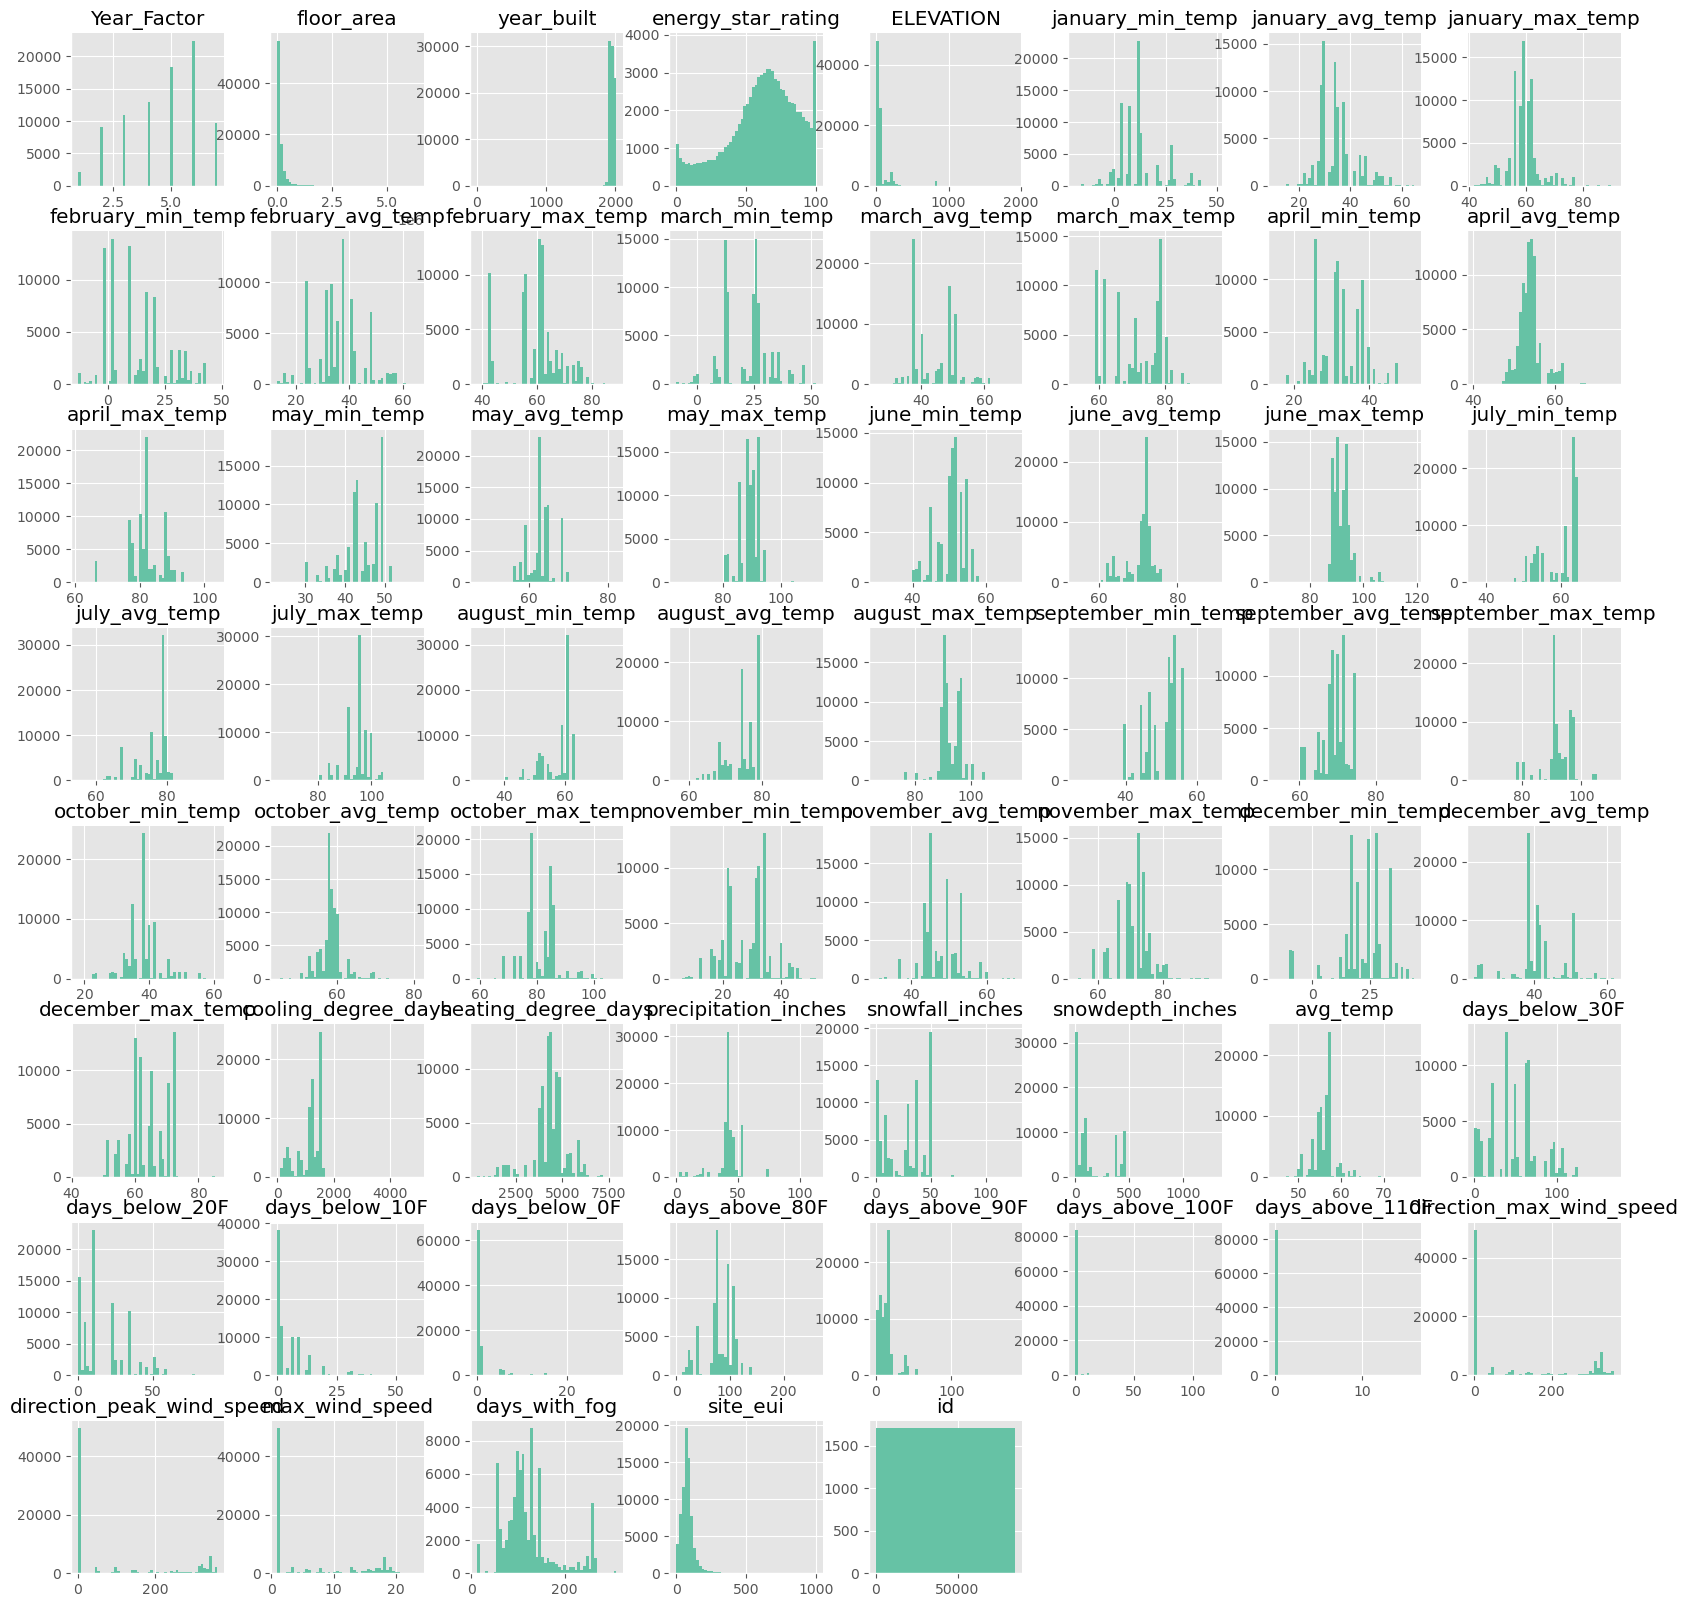

In [51]:
nums = train.loc[:, train.dtypes != 'object'].columns
df_all[nums].hist(bins=50, figsize=(20,20))
plt.show();

In [52]:
df_all_te[nums].skew().sort_values(key=abs, ascending=False)[:5]

days_above_110F    89.873857
days_above_100F    24.615438
year_built        -11.716647
floor_area          6.701786
ELEVATION           5.140444
dtype: float64

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;"> 
    Binarize very skewed variables

In [53]:
skewed = ['days_above_110F', 'days_above_100F']

for var in skewed:
    # map the variable values into 0 and 1
    df_all_te[var] = np.where(df_all_te[var]==0, 0, 1)

Saving feature dataset

In [54]:
from joblib import load
saved = True
if saved:
    data_path = '../models/feature_transformed_set_TEonly.pkl'
    with open(data_path, "rb") as fh:
        df = load(fh)
else:
    from joblib import dump
    dump(df_all, '../models/feature_transformed_set_TEonly.pkl')

In [55]:
df_all_te.shape

(85462, 96)

In [56]:
df_all_te.head()

Year_Factor  floor_area  year_built  energy_star_rating  ELEVATION  \
0          3.0     10149.0      1931.0           38.428571       45.7   
1          4.0     10149.0      1931.0           43.571429      120.4   
2          5.0     10149.0      1931.0           37.571429       59.1   
3          7.0     10149.0      1931.0           60.285714       59.1   
4          3.0     10755.0      1937.0           45.571429        9.1   

   january_min_temp  january_avg_temp  january_max_temp  february_min_temp  \
0              26.0         44.516129              64.0               30.0   
1              41.0         55.096774              73.0               42.0   
2              29.0         51.387097              77.0               36.0   
3              38.0         50.596774              64.0               40.0   
4              22.0         44.790323              65.0               25.0   

   february_avg_temp  february_max_temp  march_min_temp  march_avg_temp  \
0          49.392857               69.0            37.0       55.967742   
1          54.875000               71.0            47.0       59.032258   
2          56.803571               75.0            40.0       61.435484   
3          54.482143               66.0            42.0       56.935484   
4          47.892857               71.0            32.0       53.112903   

   march_max_temp  april_min_temp  april_avg_temp  april_max_temp  \
0            77.0            40.0       61.783333            90.0   
1            76.0            47.0       60.100000            90.0   
2            85.0            41.0       60.966667            91.0   
3            77.0            45.0       58.450000            78.0   
4            79.0            34.0       58.866667            87.0   

   may_min_temp  may_avg_temp  may_max_temp  june_min_temp  june_avg_temp  \
0          45.0     65.129032          91.0           52.0      70.016667   
1          51.0     63.483871          92.0           52.0      64.250000   
2          45.0     62.887097          90.0           55.0      72.983333   
3          49.0     60.903226          87.0           51.0      63.150000   
4          35.0     62.096774          91.0           44.0      66.283333   

   june_max_temp  july_min_temp  july_avg_temp  july_max_temp  \
0          104.0           52.0      71.387097          102.0   
1           87.0           53.0      66.903226           90.0   
2          106.0           60.0      74.516129          103.0   
3           97.0           53.0      64.258065           85.0   
4           99.0           48.0      65.693548           91.0   

   august_min_temp  august_avg_temp  august_max_temp  september_min_temp  \
0             54.0        71.322581             97.0                47.0   
1             57.0        67.016129             80.0                56.0   
2             58.0        74.774194            104.0                53.0   
3             53.0        65.854839             88.0                54.0   
4             45.0        67.080645             92.0                42.0   

   september_avg_temp  september_max_temp  october_min_temp  october_avg_temp  \
0           69.133333                98.0              43.0         61.000000   
1           68.383333                83.0              55.0         68.661290   
2           73.583333               105.0              49.0         69.580645   
3           69.766667               104.0              48.0         64.193548   
4           65.950000                96.0              35.0         56.967742   

   october_max_temp  ...  building_class     facility_type  dataset  \
0              84.0  ...      Commercial  Commercial_Other    train   
1              95.0  ...      Commercial  Commercial_Other    train   
2              96.0  ...      Commercial  Commercial_Other    train   
3              91.0  ...      Commercial  Commercial_Other     test   
4              85.0  ...      Commercial  Commercial_Other    train   

    

Baseline Modelling

In [57]:
# cats = ['State_Factor', 'facility_type', 'building_class', 'days_above_100F', 'days_above_110F']

# typecasting numerical features
for col in df_all_te.drop(columns=['dataset', 'id', 'site_eui', 'days_above_100F', 'days_above_110F','State_Factor','building_class','facility_type']).columns:
    df_all_te[col] = df_all_te[col].astype('float64')

In [58]:
train = df_all_te[df_all_te['dataset']=='train']
test = df_all_te[df_all_te['dataset']=='test']

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

test_ids = test['id']
train_ids = train['id']

target = train['site_eui'] #y_train

train = train.drop(['id', 'dataset', 'site_eui','days_above_100F', 'days_above_110F','State_Factor','building_class','facility_type'], axis=1) #X_train
test = test.drop(['id', 'dataset', 'site_eui','days_above_100F', 'days_above_110F','State_Factor','building_class','facility_type'], axis=1) #X_test

In [59]:
y_test = pd.read_csv('../data/y_test.csv')

X_train = train
X_test = test
y_train = target
y_test = y_test['site_eui']
print('Train: ', X_train.shape)
print('Test:', X_test.shape)
print('Samples: ', y_train.shape)
print('Targets: ', y_test.shape)

Train:  (75757, 88)
Test: (9705, 88)
Samples:  (75757,)
Targets:  (9705,)


Catboost

In [60]:
# get discrete end categorical features colums indexes 
# needed later for the cat bosst model
cats_discrete_idx = np.where(train.dtypes != 'float64')[0]

In [61]:
catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
#                         early_stopping_rounds=42,
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100
                        )

In [62]:
catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

y_pred = catb.predict(X_test)

0:	learn: 57.8595264	test: 61.1919764	best: 61.1919764 (0)	total: 572ms	remaining: 4m 45s
75:	learn: 44.6803974	test: 68.0140294	best: 61.1919764 (0)	total: 32.6s	remaining: 3m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 61.19197638
bestIteration = 0

Shrink model to first 1 iterations.


In [63]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 61.191976404293314
 MAE: 40.28750115757676
 MSE: 3744.4579762635894
 R2: -0.035617242914088854


XGBoost

In [64]:
xgb = XGBRegressor(n_estimators=500, reg_alpha=0.01, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [65]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 81.64041930202869
 MAE: 54.01089438087214
 MSE: 6665.158063811058
 R2: -0.8434050165301448


RandomForest

In [66]:
rf = RandomForestRegressor(random_state=1, criterion='squared_error', max_depth = 15, min_samples_split= 2)
rf.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [67]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 81.64041930202869
 MAE: 54.01089438087214
 MSE: 6665.158063811058
 R2: -0.8434050165301448


Lasso Regression

In [68]:
lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

In [69]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 75.58812283911841
 MAE: 50.785179957486065
 MSE: 5713.5643143416555
 R2: -0.580219556459058


Model Evaluation

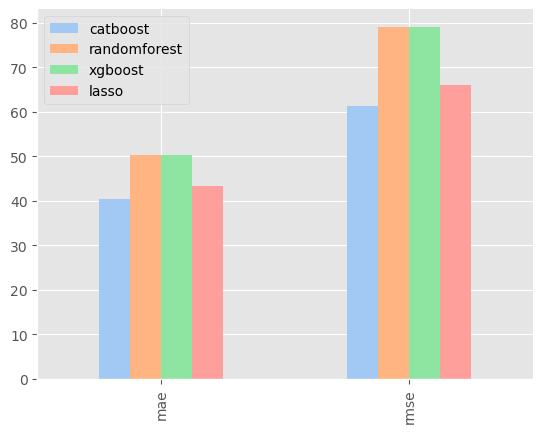

In [70]:
error_rec = {
    "catboost": {
        "mae": 40.29268484855883,
        "rmse": 61.19378120765249,
    },
    "randomforest": {
        "mae": 50.1839889322522,
        "rmse": 79.12972350643851,
    },
    "xgboost": {
         "mae": 50.1839889322522,
        "rmse": 79.12972350643851,
    },
    "lasso": {
         "mae": 43.26164501092259,
        "rmse": 66.08328222674918,
    },
}
pd.DataFrame(error_rec).plot(kind="bar", 
             color=[
                 sns.color_palette("pastel")[0], 
                 sns.color_palette("pastel")[1], 
                 sns.color_palette("pastel")[2], 
                 sns.color_palette("pastel")[3]]);

<b>Hyperparameter Tuning</b>

Using CrossValidation on CatBoost

In [71]:
# prepaere the out of folds predictions 
train_oof = np.zeros((train.shape[0],))
test_preds = np.zeros(test.shape[0])

NUM_FOLDS = 5
kf = KFold(n_splits = NUM_FOLDS, shuffle=True, random_state=0)


for fold, (train_idx, test_idx) in tqdm.tqdm(enumerate(kf.split(train, target))):
    X_train, X_test = train.iloc[train_idx][test.columns], train.iloc[test_idx][test.columns]
    y_train, y_test = target[train_idx], target[test_idx]
    
    catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
#                         early_stopping_rounds=42,
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100)
    # train model
    catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

    oof = catb.predict(X_test)
    train_oof[test_idx] = oof
    test_preds += catb.predict(test)/NUM_FOLDS      
    print(f"out-of-folds prdiction ==== fold_{fold} RMSE",np.sqrt(mean_squared_error(oof, y_test, squared=False)))

0it [00:00, ?it/s]Warning: Overfitting detector is active, thus evaluation metric is calculated on every iteration. 'metric_period' is ignored for evaluation metric.


0:	learn: 58.0635480	test: 57.0308187	best: 57.0308187 (0)	total: 378ms	remaining: 3m 8s
75:	learn: 44.9995255	test: 44.9424749	best: 44.9424749 (75)	total: 30.4s	remaining: 2m 49s
150:	learn: 42.1360396	test: 43.2282574	best: 43.2282574 (150)	total: 1m 2s	remaining: 2m 23s
225:	learn: 40.7580773	test: 42.7008249	best: 42.7008249 (225)	total: 1m 36s	remaining: 1m 56s
300:	learn: 39.7699187	test: 42.4150601	best: 42.4150601 (300)	total: 2m 10s	remaining: 1m 26s
375:	learn: 39.0235824	test: 42.2607357	best: 42.2607357 (375)	total: 2m 44s	remaining: 54.3s
450:	learn: 38.4102834	test: 42.1503441	best: 42.1503441 (450)	total: 3m 17s	remaining: 21.4s
499:	learn: 37.9709643	test: 42.0454238	best: 42.0451605 (498)	total: 3m 39s	remaining: 0us

bestTest = 42.04516052
bestIteration = 498

Shrink model to first 499 iterations.


1it [03:39, 219.96s/it]

out-of-folds prdiction ==== fold_0 RMSE 6.484223970224014


0:	learn: 57.9786178	test: 57.4605032	best: 57.4605032 (0)	total: 422ms	remaining: 3m 30s
75:	learn: 45.0564031	test: 45.5065859	best: 45.5065859 (75)	total: 40.8s	remaining: 3m 47s
150:	learn: 42.2065406	test: 43.6497167	best: 43.6497167 (150)	total: 1m 21s	remaining: 3m 7s
225:	learn: 40.9821226	test: 43.0564608	best: 43.0564608 (225)	total: 1m 56s	remaining: 2m 21s
300:	learn: 40.0516259	test: 42.7211363	best: 42.7211363 (300)	total: 2m 27s	remaining: 1m 37s
375:	learn: 39.3299719	test: 42.5007156	best: 42.5007156 (375)	total: 3m 2s	remaining: 1m
450:	learn: 38.7415453	test: 42.3339975	best: 42.3339975 (450)	total: 3m 34s	remaining: 23.3s
499:	learn: 38.3532733	test: 42.2299908	best: 42.2299908 (499)	total: 4m 3s	remaining: 0us

bestTest = 42.22999077
bestIteration = 499



2it [07:44, 234.46s/it]

out-of-folds prdiction ==== fold_1 RMSE 6.498460644096389


0:	learn: 57.6802303	test: 58.6007045	best: 58.6007045 (0)	total: 474ms	remaining: 3m 56s
75:	learn: 44.3285385	test: 47.3017238	best: 47.3017238 (75)	total: 37.1s	remaining: 3m 26s
150:	learn: 41.3641895	test: 45.7712664	best: 45.7712664 (150)	total: 1m 19s	remaining: 3m 3s
225:	learn: 39.9805091	test: 45.3489383	best: 45.3489383 (225)	total: 1m 58s	remaining: 2m 24s
300:	learn: 39.0391662	test: 45.1560042	best: 45.1560042 (300)	total: 2m 33s	remaining: 1m 41s
375:	learn: 38.3172266	test: 45.0141955	best: 45.0141955 (375)	total: 3m 7s	remaining: 1m 1s
450:	learn: 37.6522725	test: 44.9245573	best: 44.9245573 (450)	total: 3m 39s	remaining: 23.8s
499:	learn: 37.1852424	test: 44.8741858	best: 44.8740729 (498)	total: 4m 1s	remaining: 0us

bestTest = 44.8740729
bestIteration = 498

Shrink model to first 499 iterations.


3it [11:47, 238.19s/it]

out-of-folds prdiction ==== fold_2 RMSE 6.698811312057701


0:	learn: 58.4795722	test: 55.3957547	best: 55.3957547 (0)	total: 449ms	remaining: 3m 44s
75:	learn: 45.2044175	test: 43.8405863	best: 43.8405863 (75)	total: 35.3s	remaining: 3m 16s
150:	learn: 42.1600886	test: 42.2907890	best: 42.2907890 (150)	total: 1m 11s	remaining: 2m 44s
225:	learn: 40.7831194	test: 41.9512977	best: 41.9512977 (225)	total: 1m 53s	remaining: 2m 17s
300:	learn: 39.9170396	test: 41.8234118	best: 41.8218958 (299)	total: 2m 34s	remaining: 1m 41s
375:	learn: 39.2320532	test: 41.7440347	best: 41.7440347 (375)	total: 3m 12s	remaining: 1m 3s
450:	learn: 38.6181327	test: 41.6668012	best: 41.6668012 (450)	total: 3m 43s	remaining: 24.3s
499:	learn: 38.1885094	test: 41.6252652	best: 41.6252652 (499)	total: 4m 4s	remaining: 0us

bestTest = 41.62526523
bestIteration = 499



4it [15:52, 240.97s/it]

out-of-folds prdiction ==== fold_3 RMSE 6.45176450623826


0:	learn: 57.1142093	test: 60.8547154	best: 60.8547154 (0)	total: 571ms	remaining: 4m 44s
75:	learn: 44.2384313	test: 48.5252137	best: 48.5252137 (75)	total: 34.9s	remaining: 3m 14s
150:	learn: 41.4145154	test: 46.5092025	best: 46.5092025 (150)	total: 1m 9s	remaining: 2m 41s
225:	learn: 40.1294131	test: 45.8830865	best: 45.8830865 (225)	total: 1m 48s	remaining: 2m 11s
300:	learn: 39.2812305	test: 45.5773685	best: 45.5773685 (300)	total: 2m 30s	remaining: 1m 39s
375:	learn: 38.6368218	test: 45.4163864	best: 45.4156494 (374)	total: 3m 8s	remaining: 1m 2s
450:	learn: 38.1060328	test: 45.3103748	best: 45.3101356 (448)	total: 3m 47s	remaining: 24.7s
499:	learn: 37.6957713	test: 45.2185965	best: 45.2178407 (498)	total: 4m 9s	remaining: 0us

bestTest = 45.21784073
bestIteration = 498

Shrink model to first 499 iterations.


5it [20:03, 240.68s/it]

out-of-folds prdiction ==== fold_4 RMSE 6.7244212114753825


Using Optuna with Random Forest

In [72]:
# cross validating training data
kfolds = KFold(n_splits=3, shuffle=True, random_state=42)

# Objective function
def random_forest_objective(trial, data=X_train, target=y_train):
    # Dictionary to store best parameters
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "max_features": trial.suggest_float("max_features", 0.01, 0.95)
    }
     
    model = RandomForestRegressor(**param)
    
    # Setting random seed and kfolds for cross-validation
    kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
    
    scores = cross_val_score(model, data, target, cv=kfolds, scoring="neg_root_mean_squared_error")
    return scores.mean()



In [73]:
def tuner(objective, n=5, direction='minimize'): 
    # Create Study object
    study = optuna.create_study(direction="minimize")

    # Optimize the study
    study.optimize(objective, n_trials=n)

    # Print the result
    best_params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}")
    print(f"Optimized parameters: {best_params}\n")
    print("<<<<<<<<<< Tuning complete... >>>>>>>>>>")
    
    # Return best parameters for the model
    return best_params, best_score

In [74]:
%%time
rf_param, rf_score = tuner(random_forest_objective,1)
rf_tuned_model = RandomForestRegressor(**rf_param)

[I 2023-05-11 15:18:25,237] A new study created in memory with name: no-name-177190bc-fa61-43f3-aa23-ed2d4502fb12
[I 2023-05-11 15:24:37,925] Trial 0 finished with value: -44.085363895115734 and parameters: {'n_estimators': 162, 'max_depth': 8, 'min_samples_split': 7, 'max_features': 0.40855278931106426}. Best is trial 0 with value: -44.085363895115734.


Best score: -44.085363895115734
Optimized parameters: {'n_estimators': 162, 'max_depth': 8, 'min_samples_split': 7, 'max_features': 0.40855278931106426}

<<<<<<<<<< Tuning complete... >>>>>>>>>>
CPU times: total: 6min 7s
Wall time: 6min 12s


In [75]:
rf_tuned_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, max_features=0.40855278931106426,
                      min_samples_split=7, n_estimators=162)

Final Evaluation

Text(0.5, 0, 'iteration')

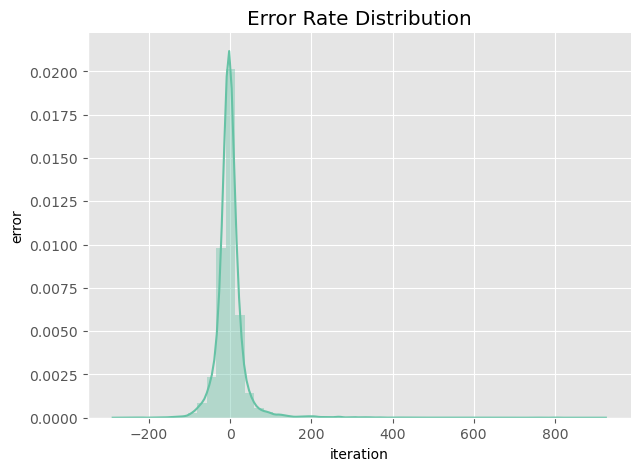

In [76]:
y_hat_tuned = catb.predict(X_test)

plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

Text(0.5, 0, 'iteration')

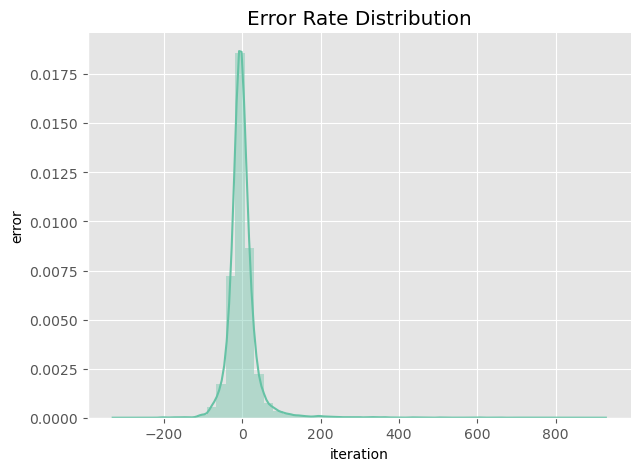

In [77]:
y_hat_tuned = rf_tuned_model.predict(X_test)

plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

Saving Models

In [78]:
with open('../models/rf_tuned_final.joblib', 'wb') as f:
    joblib.dump(rf_tuned_model, f, compress=1)

with open('../models/catb_best_final.joblib', 'wb') as f:
    joblib.dump(catb,f,compress=3)

In [79]:
## Load models here
load = False
if load:
    with open('../models/rf_tuned_final.joblib', 'rb') as f:
        rf = joblib.load(f)

    with open('../models/catb_best_final.joblib', 'rb') as f:
        catb = joblib.load(f)

Explainable AI

We will extract new weather statistics from the building location weather featurespick your sample to study the model upon

In [80]:
size = 2000

sample_exists = False

if sample_exists:
    sample_set = pd.read_csv('../data/shap/sample2000.csv')
else:
    sample_set = X_test.sample(size)
sample_set

Year_Factor  floor_area  year_built  energy_star_rating  ELEVATION  \
75393          5.0     83000.0      1990.0           54.571429      269.7   
21714          2.0    111329.0      1930.0           67.142857       11.9   
74544          5.0    265093.0      1976.0           74.714286       18.3   
17408          5.0     80584.0      1905.0           53.000000      232.0   
7525           6.0    116640.0      1911.0           75.000000       26.5   
...            ...         ...         ...                 ...        ...   
17010          6.0    113032.0      1970.0           69.714286      205.7   
59865          5.0    115664.0      1963.0           82.000000       42.7   
40235          3.0     57200.0      1977.0           63.428571       11.9   
66302          5.0    188767.0      1987.0            9.000000       15.2   
69936          4.0    349005.0      1962.0           70.000000        3.4   

       january_min_temp  january_avg_temp  january_max_temp  \
75393               3.0         24.016129              49.0   
21714              13.0         37.322581              62.0   
74544               3.0         24.016129              49.0   
17408              -9.0         21.403226              42.0   
7525               28.0         43.451613              56.0   
...                 ...               ...               ...   
17010              -2.0         25.166667              50.0   
59865               8.0         29.854839              56.0   
40235              11.0         35.080645              61.0   
66302               8.0         29.854839              56.0   
69936               4.0         28.596774              58.0   

       february_min_temp  february_avg_temp  february_max_temp  \
75393               -5.0          18.910714               44.0   
21714               20.0          40.879310               62.0   
74544               -5.0          18.910714               44.0   
17408               -7.0          14.981481               42.0   
7525                34.0          47.672414               64.0   
...                  ...                ...                ...   
17010                2.0          29.711538               65.0   
59865                2.0          23.946429               43.0   
40235               17.0          33.910714               55.0   
66302                2.0          23.946429               43.0   
69936                9.0          31.625000               56.0   

       march_min_temp  march_avg_temp  march_max_temp  april_min_temp  \
75393            -1.0       32.532258            65.0            25.0   
21714            25.0       50.935484            78.0            38.0   
74544            -1.0       32.532258            65.0            25.0   
17408            -3.0       34.048387            74.0            29.0   
7525             35.0       49.354839            71.0            40.0   
...               ...             ...             ...             ...   
17010            12.0       44.516129            73.0            23.0   
59865            12.0       38.096774            62.0            32.0   
40235            27.0       40.145161            59.0            33.0   
66302            12.0       38.096774            62.0            32.0   
69936            13.0       37.661290            66.0            31.0   

       april_avg_temp  april_max_temp  may_min_temp  may_avg_temp  \
75393       49.533333            79.0          39.0     64.145161   
21714       54.766667            88.0          49.0     65.096774   
74544       49.533333            79.0          39.0     64.145161   
17408       51.000000            77.0          36.0     61.903226   
7525        56.266667            89.0          45.0     59.193548   
...               ...             ...           ...           ...   
17010       49.017241            88.0          38.0     61.933333   
59865       54.250000            80.0          48.0     68.516129   
40235       52.983333            8

Calculate shap values

In [81]:
is_saved = False

if is_saved:
    with open('../data/shap/shap_values_sample2000.pkl', 'rb') as f:
        shap_values = joblib.load(f)
else:
    shap_values = shap.TreeExplainer(rf).shap_values(sample_set)

In [82]:
shap.initjs()

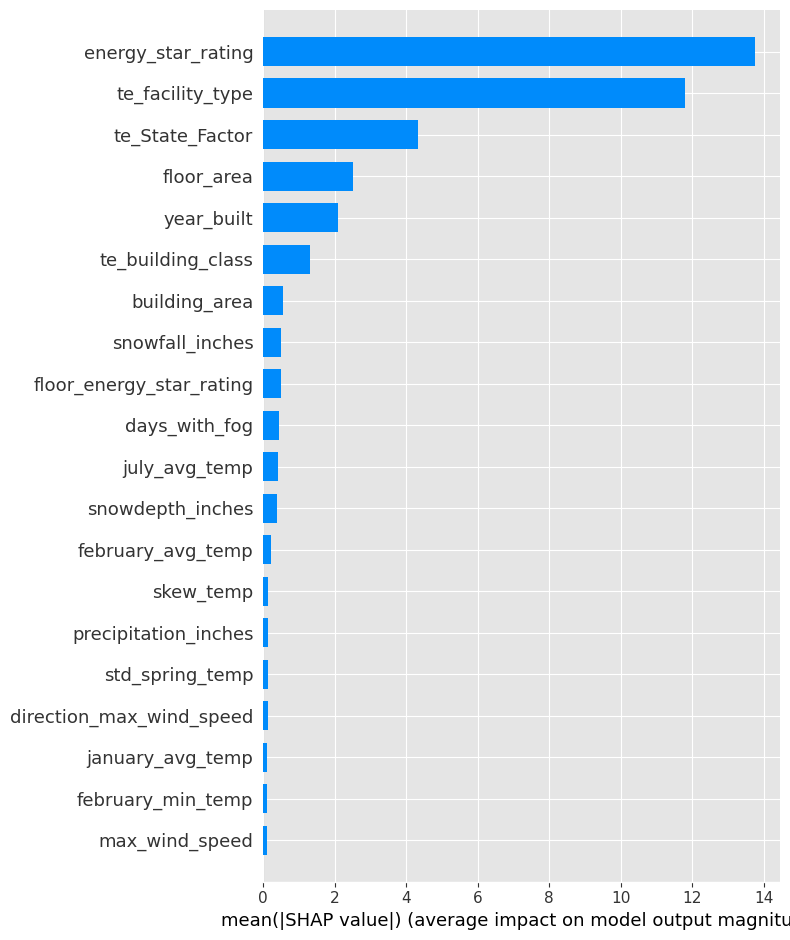

In [83]:
shap.summary_plot(shap_values, sample_set, plot_type="bar")

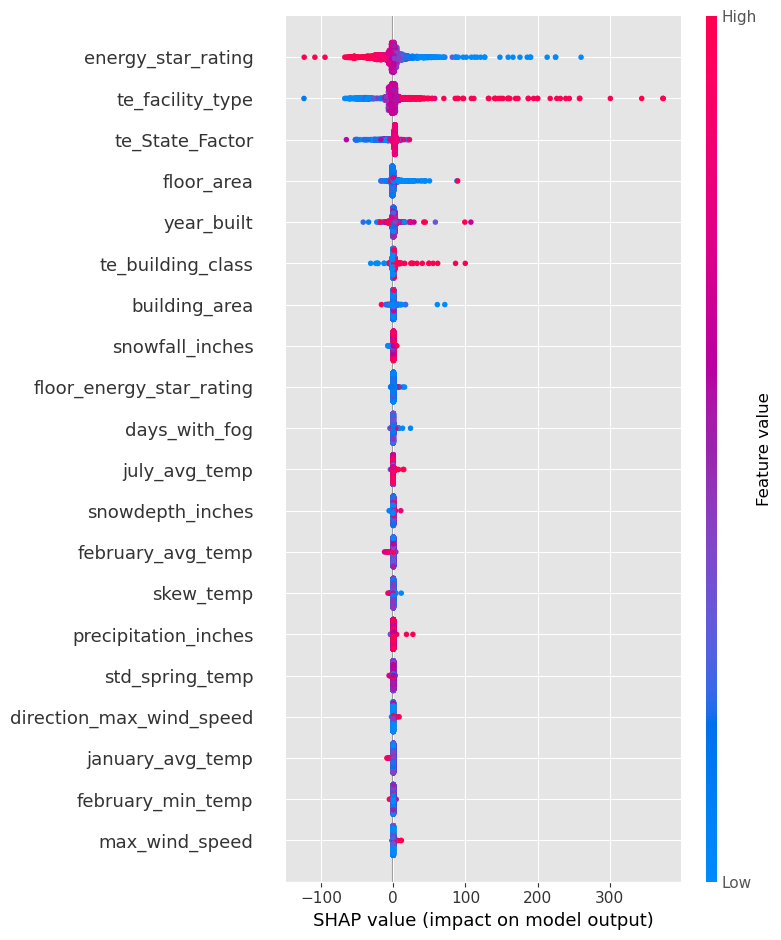

In [84]:
shap.summary_plot(shap_values, sample_set)

In [85]:
limit = 200
shap.force_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], shap_values[0:limit,:], sample_set.iloc[0:limit,:])

In [86]:
row = 60
print(y_pred[row])
shap.initjs()
shap.force_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], shap_values[row], sample_set.iloc[row])

111.60976575180587


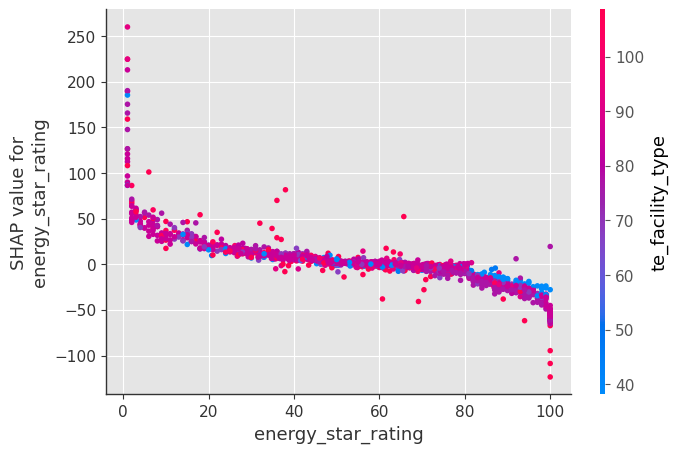

In [87]:
shap.dependence_plot('energy_star_rating', shap_values, sample_set)

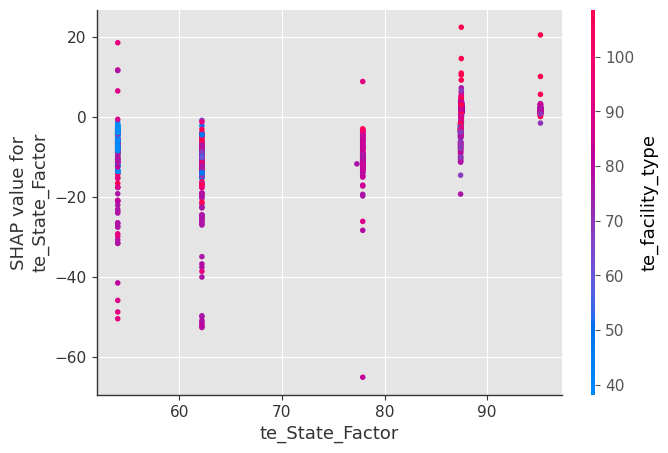

In [88]:
shap.dependence_plot('te_State_Factor', shap_values, sample_set)

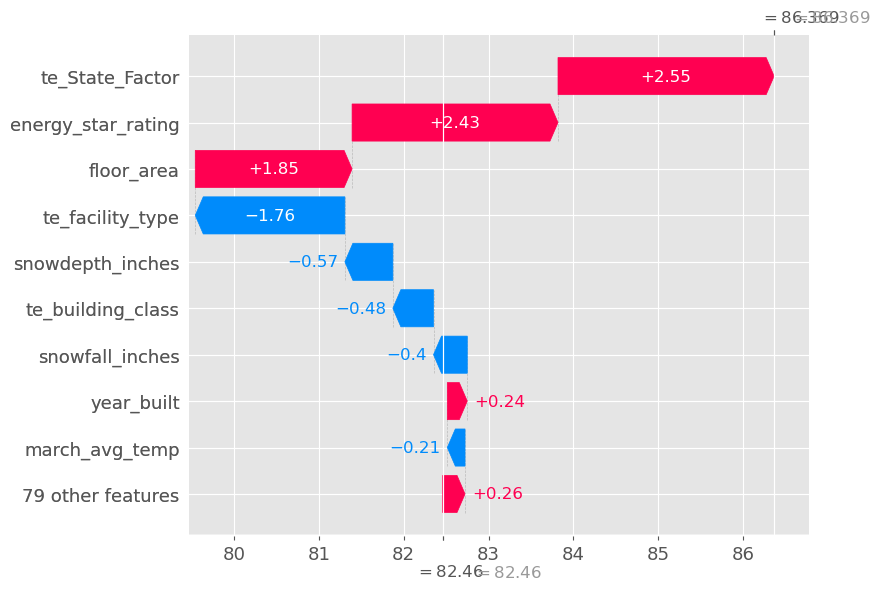

In [89]:
row = 111
shap.plots._waterfall.waterfall_legacy(shap.TreeExplainer(rf_tuned_model).expected_value[0], 
                                       shap_values[row],
                                       feature_names=sample_set.columns.tolist()
                                      )

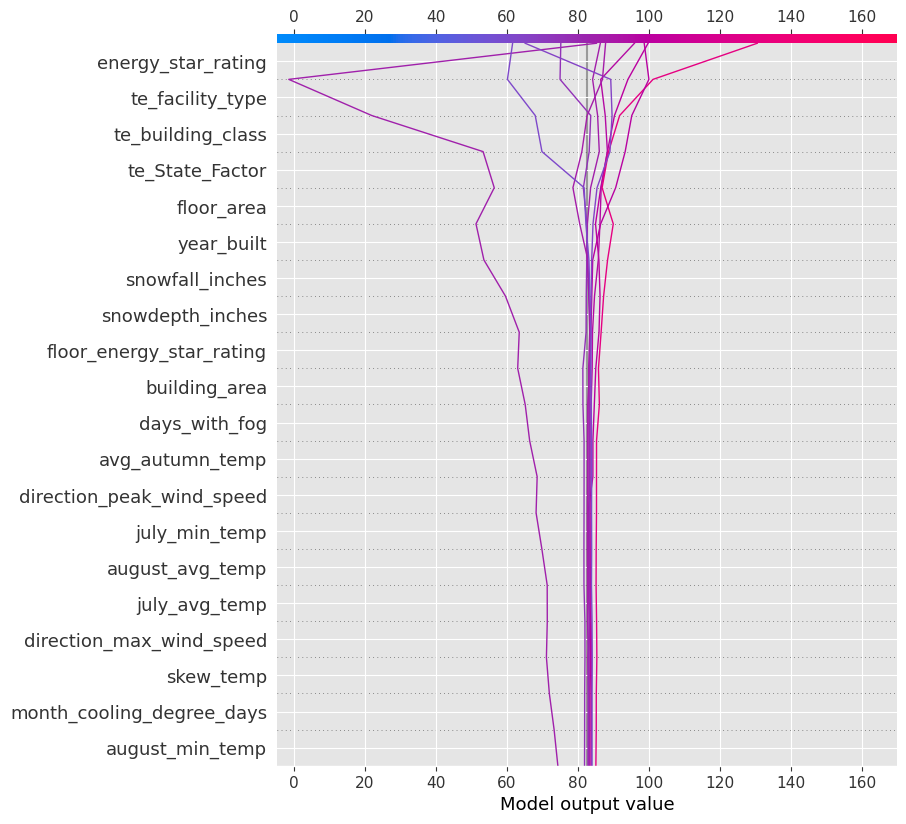

In [90]:
start = 120
limit = 130

shap.decision_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], 
                   shap_values[start:limit], 
                   feature_names=sample_set.columns.tolist())

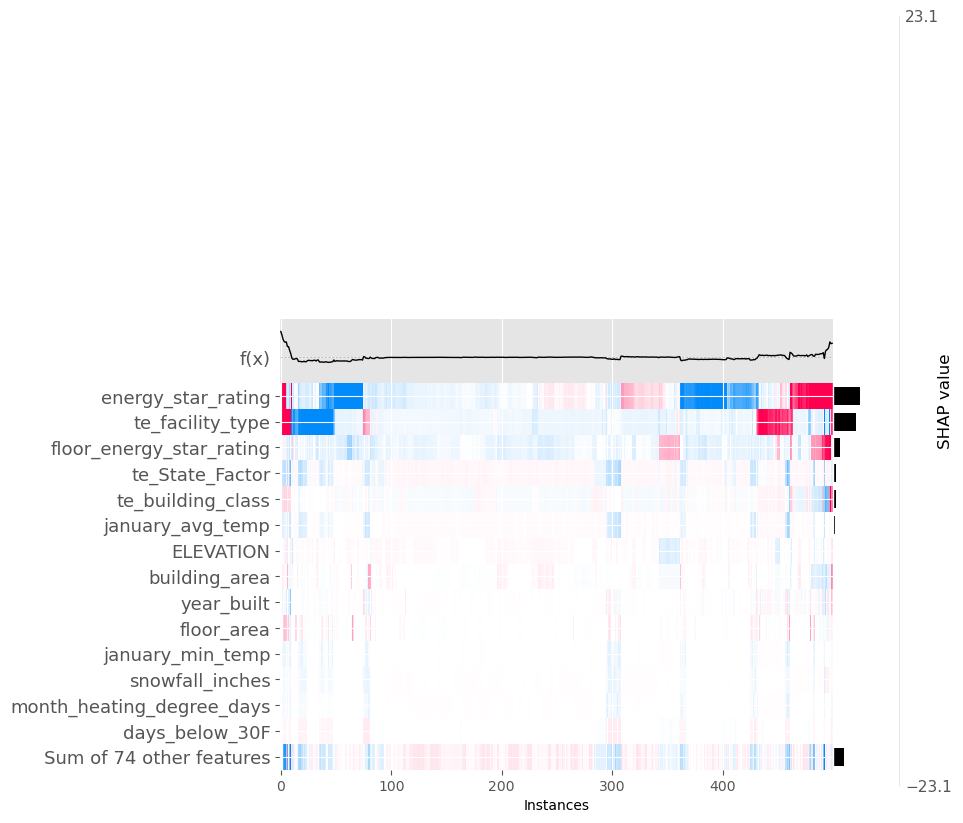

In [91]:
limit = 500
shap.plots.heatmap(shap.TreeExplainer(rf_tuned_model, data=sample_set)(sample_set[:limit]), max_display=15)